- CNN pour la clacification du dataset avec les 10 catégorie https://keras.io/api/datasets/cifar10/
- Model inspiration : [link](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- Fine tuning de mobilenet (ajout d'un dense layer pour catégorisation)

## Step 0: Mac M2 GPU

- The Neural Engine is primarily used for inference through Core ML
- TensorFlow training uses the GPU cores via Metal Performance Shaders (MPS)
- As of 2024, use Python 3.11 with TensorFlow 2.15.1 and tensorflow-metal 1.1.0 for best compatibility

In [27]:
%pip install tensorflow-metal
%pip install tensorflow-macos

# Step 1: System Information and TensorFlow Configuration
import sys
import platform
import subprocess
import tensorflow as tf

print("="*80)
print(" "*25 + "SYSTEM INFORMATION")
print("="*80)

# System details
print(f"\n📱 Platform: {platform.platform()}")
print(f"🏗️ Architecture: {platform.machine()}")
print(f"🐍 Python Version: {sys.version}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Check for tensorflow-metal
try:
    import tensorflow_metal
    print(f"TensorFlow Metal: Installed")
except ImportError:
    print("TensorFlow Metal: Not installed - GPU acceleration unavailable!")
    print("   Install with: pip install tensorflow-metal")

# Check macOS version
try:
    macos_version = subprocess.check_output(['sw_vers', '-productVersion']).decode().strip()
    print(f"macOS Version: {macos_version}")
    
    # Verify minimum version (12.0 required for Metal)
    major, minor = map(int, macos_version.split('.')[:2])
    if major < 12:
        print("WARNING: macOS 12.0+ required for Metal GPU support!")
except:
    pass

print("\n" + "="*80)
print(" "*25 + "GPU DETECTION & VERIFICATION")
print("="*80)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                         SYSTEM INFORMATION

📱 Platform: macOS-15.6.1-arm64-arm-64bit
🏗️ Architecture: arm64
🐍 Python Version: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
📦 TensorFlow Version: 2.16.2
TensorFlow Metal: Not installed - GPU acceleration unavailable!
   Install with: pip install tensorflow-metal
macOS Version: 15.6.1

                         GPU DETECTION & VERIFICATION


In [28]:
# Step 2: GPU Detection and Configuration
print("\n Detecting available devices...")

# List all physical devices
devices = tf.config.list_physical_devices()
print(f"\nAll devices found: {len(devices)}")
for device in devices:
    print(f"   - {device}")

# Check specifically for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU DETECTED! Found {len(gpus)} GPU device(s)")
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i} Details:")
        print(f"   Device: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            for key, value in details.items():
                print(f"   {key}: {value}")
        except:
            print(" (Unable to get detailed GPU information)")
    
    # Configure GPU memory growth
    print("\n Configuring GPU memory growth...")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled - GPU will allocate memory as needed")
    except RuntimeError as e:
        print(f" Could not set memory growth: {e}")
        
else:
    print("\n NO GPU DETECTED!")
    print("   Possible reasons:")
    print("   1. tensorflow-metal not installed")
    print("   2. Incompatible TensorFlow version")
    print("   3. System doesn't have compatible GPU")
    print("\n   To install tensorflow-metal:")
    print("   pip install tensorflow-metal==1.1.0")

# Enable device placement logging
print("\n📍 Enabling device placement logging...")
tf.debugging.set_log_device_placement(False)


 Detecting available devices...

All devices found: 2
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU DETECTED! Found 1 GPU device(s)

GPU 0 Details:
   Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   device_name: METAL

 Configuring GPU memory growth...
 Memory growth enabled - GPU will allocate memory as needed

📍 Enabling device placement logging...


# Step 1: Initialisation

In [29]:
# MINIMAL REQUIREMENTS 

# Python 
import sys
assert sys.version_info >= (3,11)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# COLAB DETECTION 

try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TENSORFLOW
import tensorflow as tf
assert tf.__version__ >= "2.16"


# COMMON IMPORTS
import numpy as np
import os
from datetime import datetime


# REPRODUCTIBILITY
np.random.seed(42)
tf.random.set_seed(42)

# MATPLOTLIB CONFIGURATION
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# Step 2: load the data

In [ ]:
from tf.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


# Step : Data preparation

In [31]:
# Create the validation set from the train set
# Take 20% (0.2) of the total set (50000 * 0.2 = 10000 record)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# One hot encode target values
y_train_new = tf.keras.utils.to_categorical(y_train_new, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Format in float32 and normalize to [0,1]
X_train_new = X_train_new.astype('float32') / 255.0
X_val       = X_val.astype('float32') / 255.0
X_test      = X_test.astype('float32') / 255.0

# Define class name
classNames = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']




# Step : Display data and stuff

(40000, 10)
(10000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


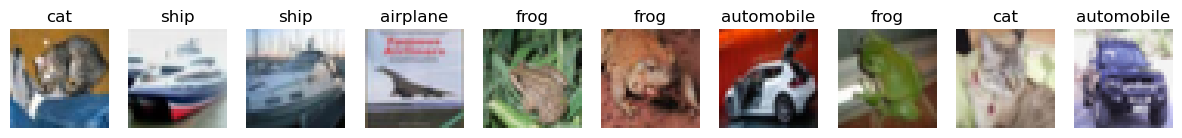

In [32]:
print(y_train_new.shape)
print(y_val.shape)
print(y_test.shape)

print(y_train_new[0])
print(y_val[0])
print(y_test[0])

fig, ax = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    ax[i].axis('off')
    cls_idx = np.argmax(y_test[i])
    ax[i].set_title(classNames[cls_idx])
    ax[i].imshow(X_test[i])
plt.show()

# Step : Define models

In [33]:
'''
    small : Start simple
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    medium : Add 1 layer with Conv 128
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 2 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    large : Add 1 Conv in each layer
    - Layer 1 : 3 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    X-Large : Double filters on each layer + adapte dense layer to match
    - Layer 1 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 256 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 256 + BatchNorm + Dropout(0.5) + Dense soft max

'''

def create_model(model_name="small"):
    if model_name == "small":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "medium":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "X_large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


# Step : Define optimizers

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


# Step : Compile and display the model

In [35]:

model = create_model("small") 
model.compile(loss="categorical_crossentropy",
              optimizer=opt, 
              metrics=['accuracy'])
# Show model shape
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

# Step : Preprocess for training

In [36]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train the small model

In [37]:
history_small = model.fit(train_ds, epochs=1, validation_data=val_ds)

625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.4610 - loss: 1.5967 - val_accuracy: 0.5938 - val_loss: 1.1520


# Step : Define Plot function

In [38]:

def plot_result(history):
    # Create subplots for Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Step : Run plot results function

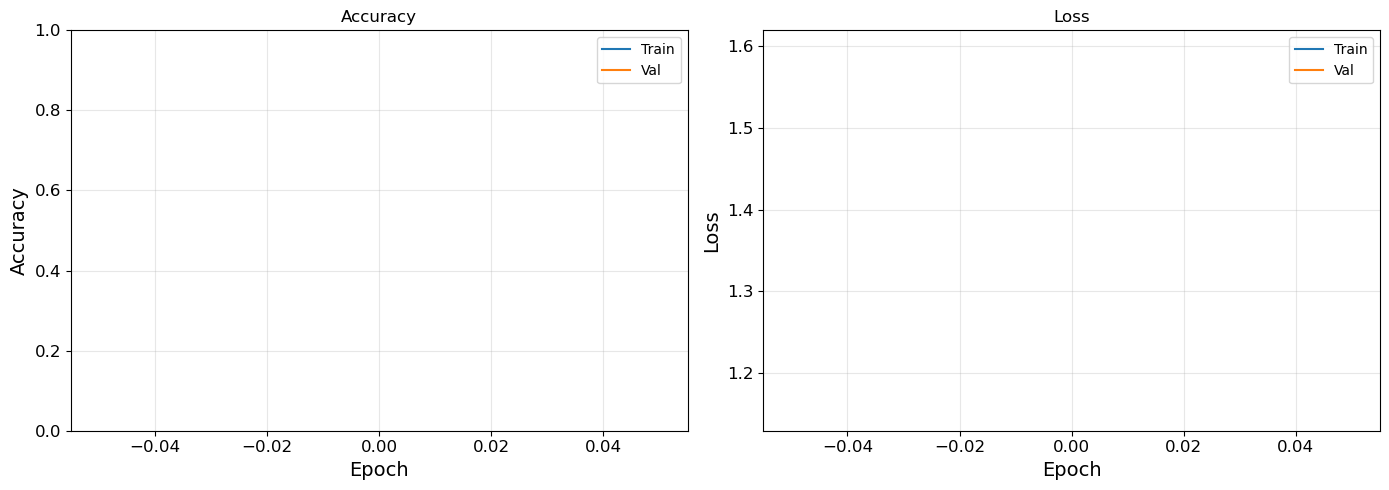

In [39]:
plot_result(history_small)

# Step : Define Evaluation function

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def evaluate_and_report(model, X_test, y_test, class_names, batch_size=256):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    y_prob = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        "accuracy": test_acc,
        "loss": test_loss
    }

# Step : Run Evaluation function

Test Accuracy: 0.5922



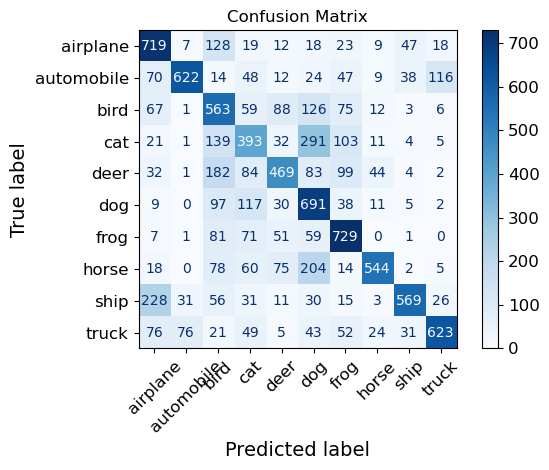

Classification Report:

              precision    recall  f1-score   support

    airplane       0.58      0.72      0.64      1000
  automobile       0.84      0.62      0.71      1000
        bird       0.41      0.56      0.48      1000
         cat       0.42      0.39      0.41      1000
        deer       0.60      0.47      0.53      1000
         dog       0.44      0.69      0.54      1000
        frog       0.61      0.73      0.66      1000
       horse       0.82      0.54      0.65      1000
        ship       0.81      0.57      0.67      1000
       truck       0.78      0.62      0.69      1000

    accuracy                           0.59     10000
   macro avg       0.63      0.59      0.60     10000
weighted avg       0.63      0.59      0.60     10000



{'accuracy': 0.592199981212616, 'loss': 1.1559008359909058}

In [41]:
evaluate_and_report(model, X_test, y_test, class_names=classNames)

# Step : Define training and evaluation functions

In [ ]:
import json
import tensorflow as tf
from types import SimpleNamespace

class TrainAndEvaluateModel:
    def __init__(self, model_name=None,
                 train_ds=None, 
                 val_ds=None,
                 optimizer=None, 
                 loss_fn=None, 
                 epochs=5,
                 callbacks=None,
                 X_test=None, 
                 y_test=None, 
                 class_names=None,
                 force=False,
                 model_summary=False,
                 base_dir="saved_models"
                 ):
        
        self.model_name = model_name
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.callbacks = callbacks   # ✅ if None, ignored
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.force = force
        self.model_summary = model_summary

        # 🔥 one fixed directory per model name
        self.save_dir = os.path.join(base_dir, self.model_name)
        os.makedirs(self.save_dir, exist_ok=True)

        # Paths
        self.save_path = os.path.join(self.save_dir, f"{self.model_name}_model.keras")
        self.history_path = os.path.join(self.save_dir, f"{self.model_name}_history.json")
        self.metrics_path = os.path.join(self.save_dir, f"{self.model_name}_metrics.json")
        self.best_weights_path = os.path.join(self.save_dir, "best_model.weights.h5")

        self.model = None
        self.history = None
        self.metrics = None

    def train_model(self):
        # Case 1: Resume from best weights if they exist
        if os.path.exists(self.best_weights_path) and not self.force:
            print(f"Resuming from best checkpoint: {self.best_weights_path}")
            self.model = create_model(self.model_name)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            self.model.load_weights(self.best_weights_path)

            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Case 2: Resume from last full model
        elif os.path.exists(self.save_path) and not self.force:
            print(f"Loading last trained model: {self.save_path}")
            self.model = tf.keras.models.load_model(self.save_path)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Case 3: Train from scratch
        else:
            if self.force:
                print(f"Forcing retrain for model: {self.model_name}")
            else:
                print(f"Training new model: {self.model_name}")

            self.model = create_model(self.model_name)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            if self.model_summary:
                print(f"Summary for model: {self.model_name}")
                self.model.summary()
            else:
                print("Summary disabled")

            # ✅ only pass callbacks if defined
            fit_kwargs = {
                "x": self.train_ds,
                "epochs": self.epochs,
                "verbose": 1,
                "validation_data": self.val_ds
            }
            if self.callbacks is not None:
                fit_kwargs["callbacks"] = self.callbacks

            self.history = self.model.fit(**fit_kwargs)

            # Save last full model (new .keras format)
            self.model.save(self.save_path)
            print(f"✅ Last model saved to {self.save_path}")

            with open(self.history_path, "w") as f:
                json.dump(self.history.history, f)
            print(f"✅ History saved to {self.history_path}")

        return self.model, self.history

    def load_best_weights(self):
        if os.path.exists(self.best_weights_path):
            print(f"Loading best weights from {self.best_weights_path}")
            best_model = create_model(self.model_name)
            best_model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            best_model.load_weights(self.best_weights_path)
            self.model = best_model
        else:
            print("⚠️ No best_model.weights.h5 found, using current model.")

    def evaluate_model(self):
        if self.history is not None:
            plot_result(self.history)

        self.metrics = evaluate_and_report(
            self.model,
            self.X_test,
            self.y_test,
            class_names=self.class_names
        )

        with open(self.metrics_path, "w") as f:
            json.dump(self.metrics, f)
        print(f"✅ Metrics saved to {self.metrics_path}")

        return self.metrics

    def run(self):
        self.train_model()
        self.load_best_weights()
        self.evaluate_model()
        return {
            "model": self.model,
            "history": self.history,
            "metrics": self.metrics
        }


# Step : Use training and evaluation function

Training model: small
Loading last trained model: saved_models/results/small/small_model.keras
⚠️ No best_model.weights.h5 found, using current model.


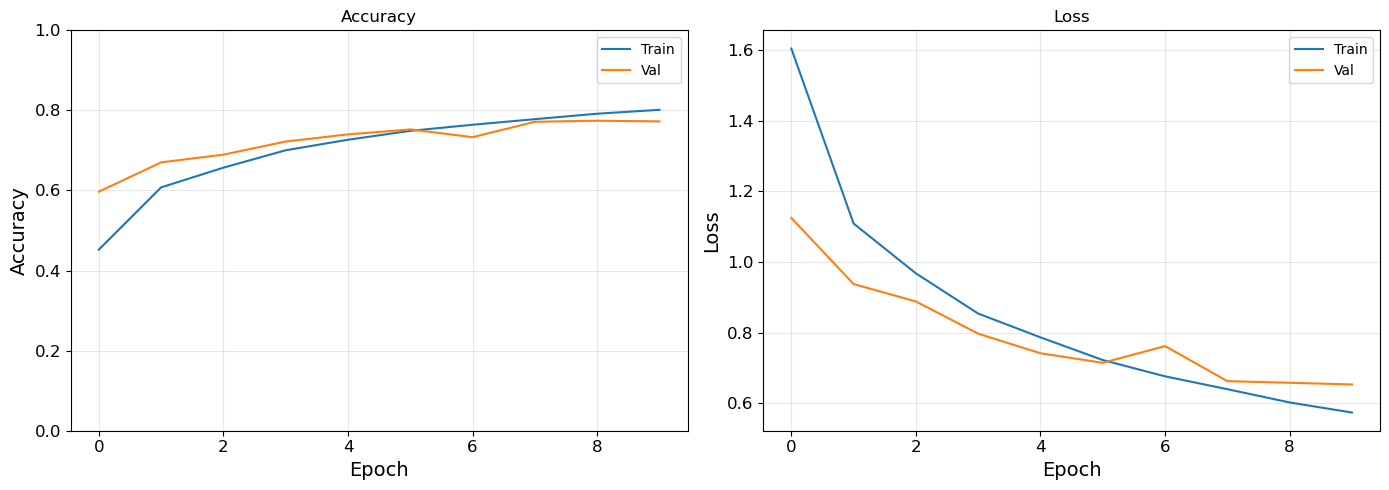

Test Accuracy: 0.7731



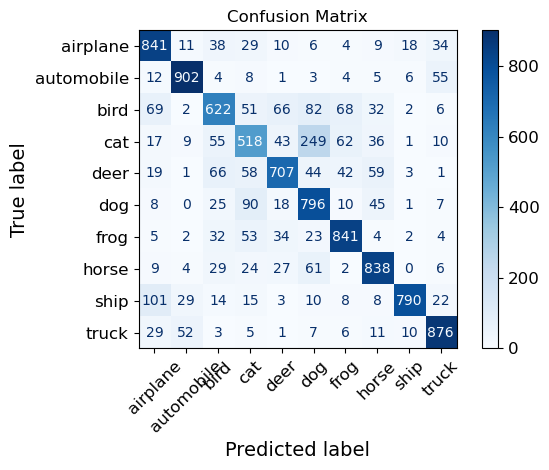

Classification Report:

              precision    recall  f1-score   support

    airplane       0.76      0.84      0.80      1000
  automobile       0.89      0.90      0.90      1000
        bird       0.70      0.62      0.66      1000
         cat       0.61      0.52      0.56      1000
        deer       0.78      0.71      0.74      1000
         dog       0.62      0.80      0.70      1000
        frog       0.80      0.84      0.82      1000
       horse       0.80      0.84      0.82      1000
        ship       0.95      0.79      0.86      1000
       truck       0.86      0.88      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

✅ Metrics saved to saved_models/results/small/small_metrics.json
Training model: medium
Loading last trained model: saved_models/results/medium/medium_model.keras
⚠️ No best_model.weights.h5 found, using current model

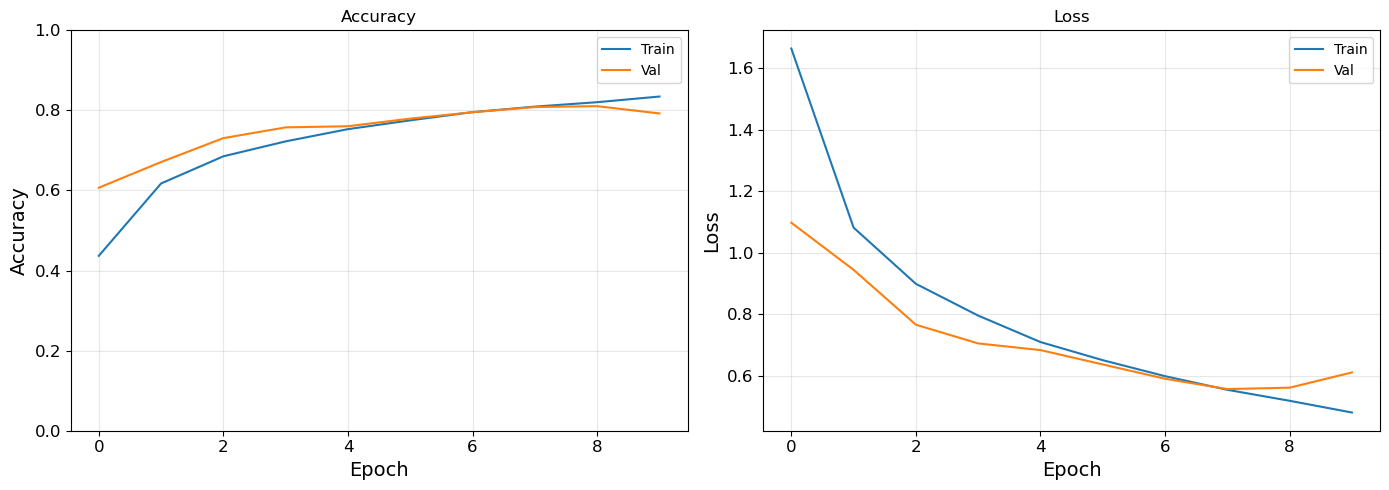

Test Accuracy: 0.7890



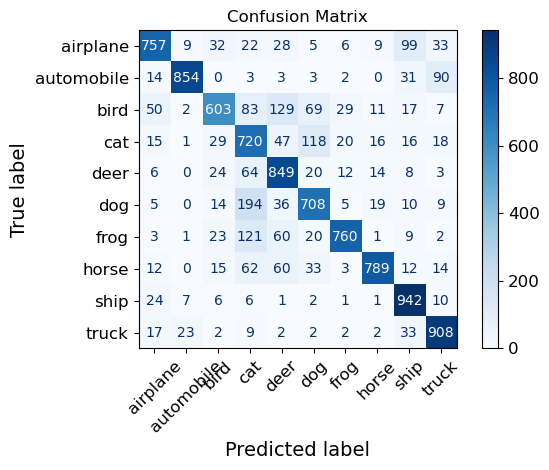

Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.76      0.80      1000
  automobile       0.95      0.85      0.90      1000
        bird       0.81      0.60      0.69      1000
         cat       0.56      0.72      0.63      1000
        deer       0.70      0.85      0.77      1000
         dog       0.72      0.71      0.72      1000
        frog       0.90      0.76      0.83      1000
       horse       0.92      0.79      0.85      1000
        ship       0.80      0.94      0.87      1000
       truck       0.83      0.91      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

✅ Metrics saved to saved_models/results/medium/medium_metrics.json
Training model: large
Loading last trained model: saved_models/results/large/large_model.keras
⚠️ No best_model.weights.h5 found, using current model.

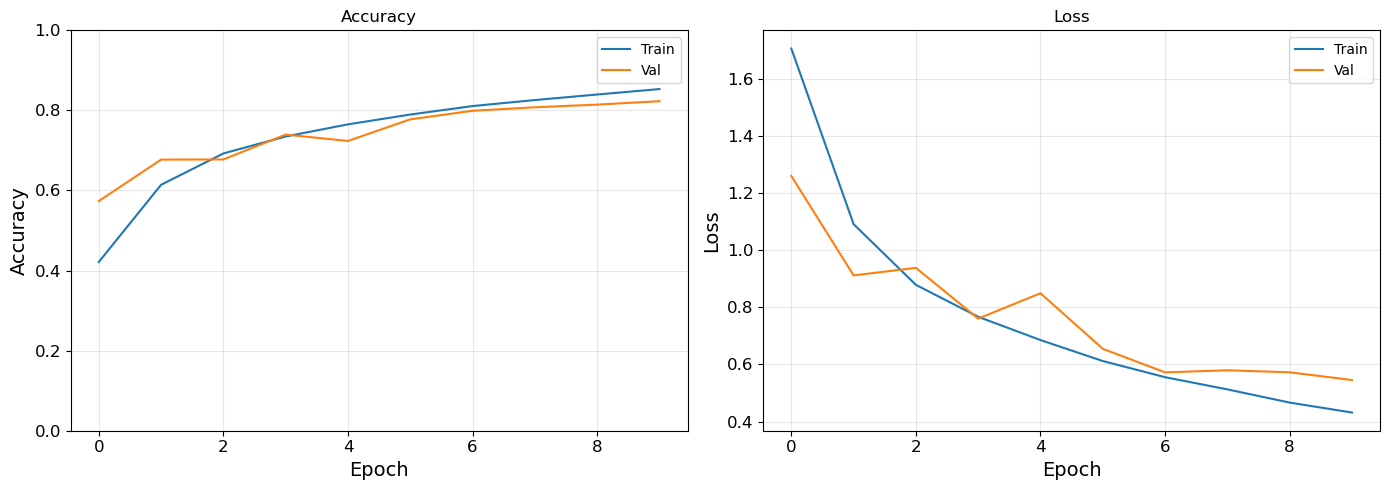

Test Accuracy: 0.8191



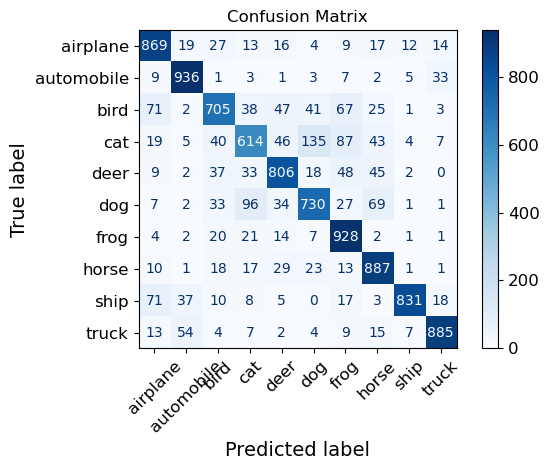

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.87      0.83      1000
  automobile       0.88      0.94      0.91      1000
        bird       0.79      0.70      0.74      1000
         cat       0.72      0.61      0.66      1000
        deer       0.81      0.81      0.81      1000
         dog       0.76      0.73      0.74      1000
        frog       0.77      0.93      0.84      1000
       horse       0.80      0.89      0.84      1000
        ship       0.96      0.83      0.89      1000
       truck       0.92      0.89      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

✅ Metrics saved to saved_models/results/large/large_metrics.json
Training model: X_large
Loading last trained model: saved_models/results/X_large/X_large_model.keras
⚠️ No best_model.weights.h5 found, using current mo

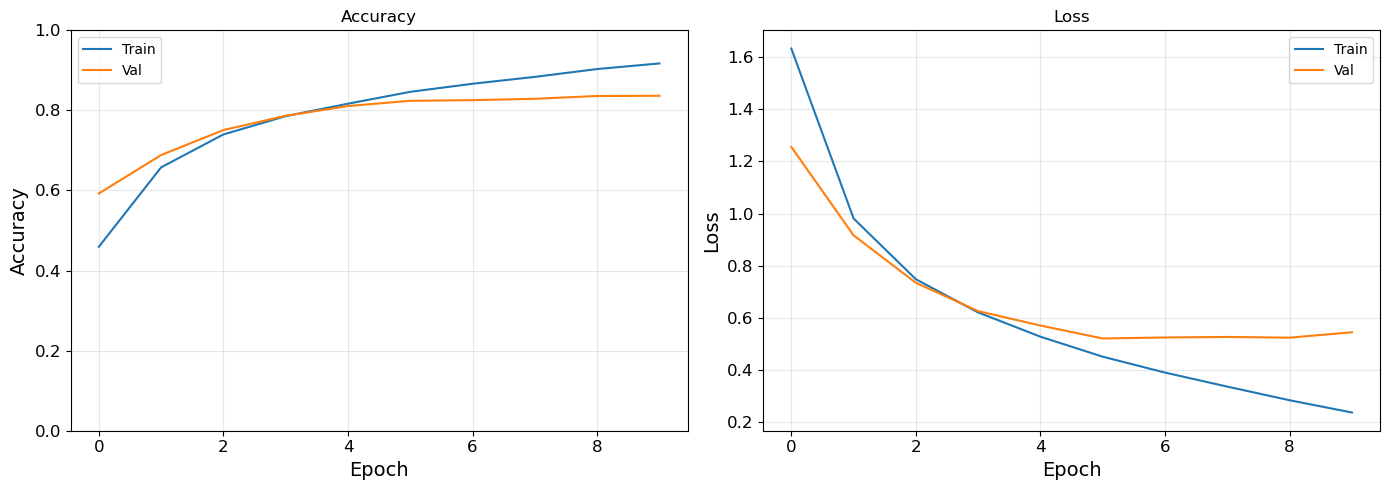

Test Accuracy: 0.8296



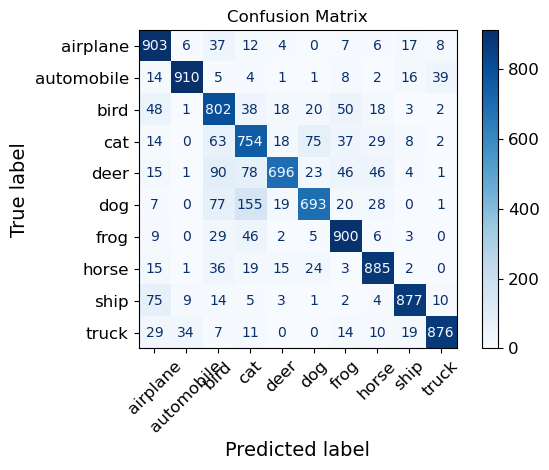

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.90      0.85      1000
  automobile       0.95      0.91      0.93      1000
        bird       0.69      0.80      0.74      1000
         cat       0.67      0.75      0.71      1000
        deer       0.90      0.70      0.78      1000
         dog       0.82      0.69      0.75      1000
        frog       0.83      0.90      0.86      1000
       horse       0.86      0.89      0.87      1000
        ship       0.92      0.88      0.90      1000
       truck       0.93      0.88      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

✅ Metrics saved to saved_models/results/X_large/X_large_metrics.json


In [43]:
model_names = ["small", "medium", "large", "X_large"]
results = {}

for name in model_names:
    print(f"Training model: {name}")
    
    trainer = TrainAndEvaluateModel(
        model_name=name,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=tf.keras.optimizers.Adam(),
        loss_fn="categorical_crossentropy",
        epochs=10,
        X_test=X_test,
        y_test=y_test,
        class_names=classNames,
        force=False,
        base_dir="saved_models/results"
    )

    results[name] = trainer.run()


# Step : Compare models accuracy

In [44]:
for name, result in results.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")



small           | Test Accuracy: 0.7731
medium          | Test Accuracy: 0.7890
large           | Test Accuracy: 0.8191
X_large         | Test Accuracy: 0.8296


# Step : Add callback function

In [45]:

def get_callbacks(save_dir):
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-9
    )

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, "best_model.weights.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=False,
        verbose=1
    )

    return [lr_scheduler, checkpoint_cb, earlystop_cb]


# Step : Add simple data augmentation

In [46]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
])

# Step : Update Preprocess for training


In [47]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .map(lambda x, y: (augment(x, training=True), y),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train with data augmentation

Training model: small
Training new model: small
Summary disabled
Epoch 1/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3036 - loss: 2.1942
Epoch 1: val_loss improved from None to 1.29965, saving model to saved_models/results2/small/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.3638 - loss: 1.8760 - val_accuracy: 0.5308 - val_loss: 1.2996 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4776 - loss: 1.4476
Epoch 2: val_loss improved from 1.29965 to 1.08269, saving model to saved_models/results2/small/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.4974 - loss: 1.3939 - val_accuracy: 0.6136 - val_loss: 1.0827 - learning_rate: 0.0010
Epoch 3/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5546 - loss: 1.2414
Epoch 3: val_loss improved from 1.08269 to 1.03035, saving model to saved_models/results2/small/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 4

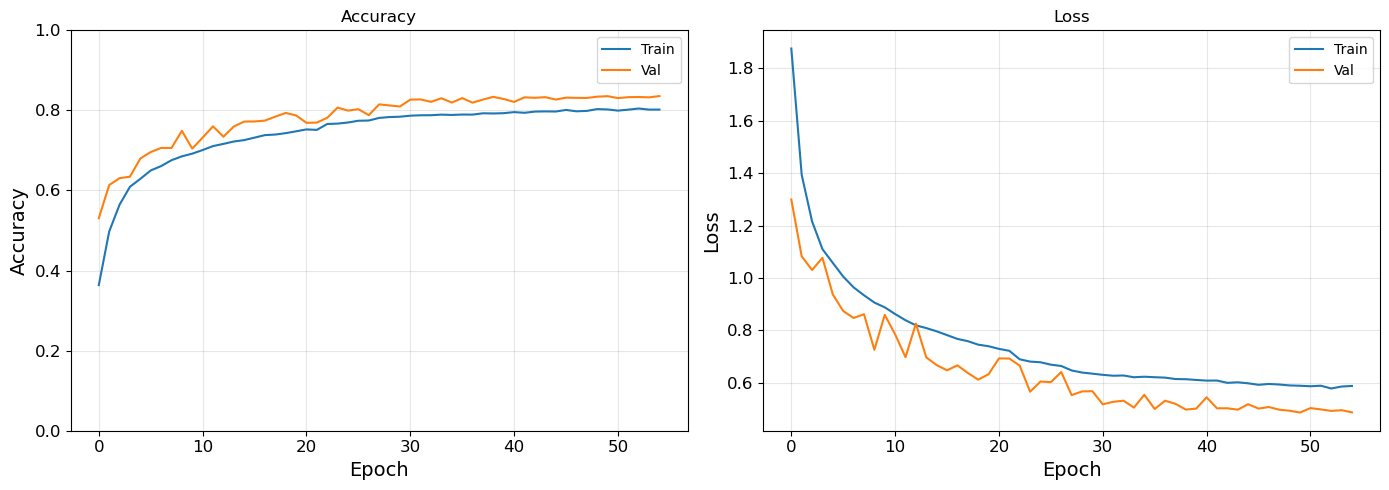

Test Accuracy: 0.8339



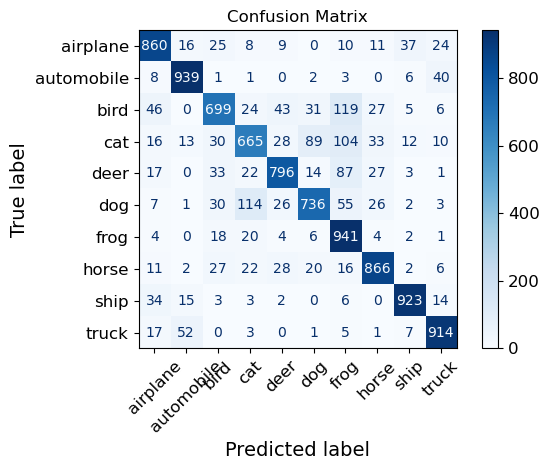

Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.86      0.85      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.81      0.70      0.75      1000
         cat       0.75      0.67      0.71      1000
        deer       0.85      0.80      0.82      1000
         dog       0.82      0.74      0.78      1000
        frog       0.70      0.94      0.80      1000
       horse       0.87      0.87      0.87      1000
        ship       0.92      0.92      0.92      1000
       truck       0.90      0.91      0.91      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

✅ Metrics saved to saved_models/results2/small/small_metrics.json
Training model: medium
Training new model: medium
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2788 - loss: 2.3

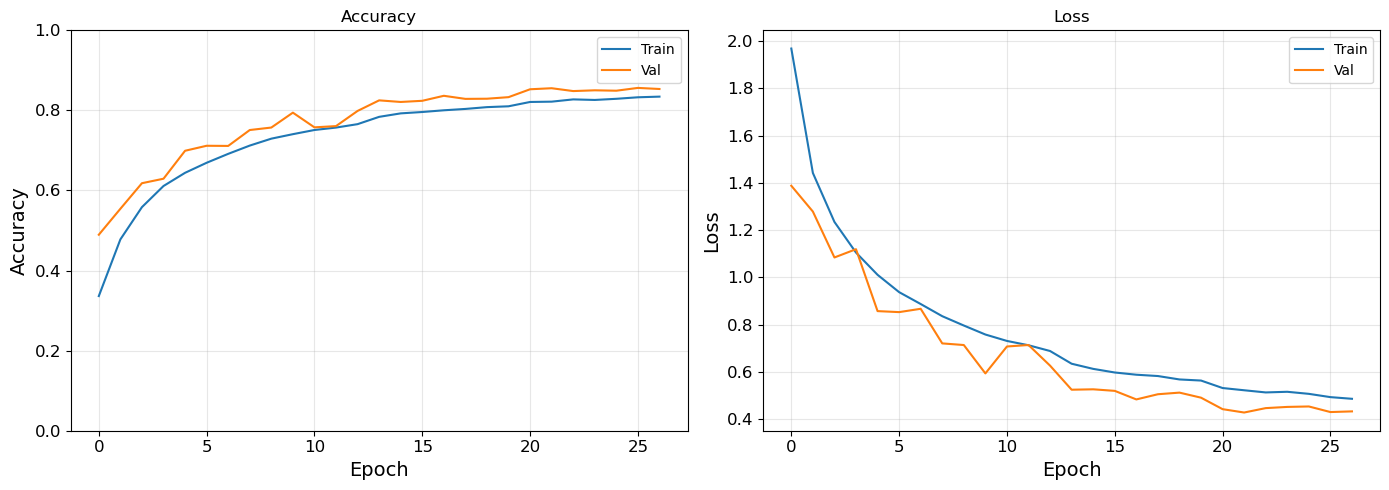

Test Accuracy: 0.8508



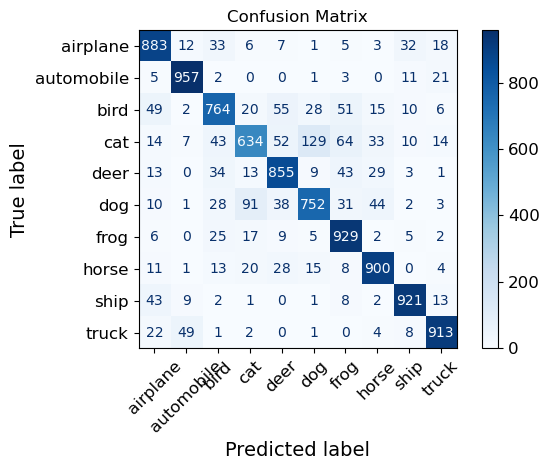

Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.88      0.86      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.81      0.76      0.79      1000
         cat       0.79      0.63      0.70      1000
        deer       0.82      0.85      0.84      1000
         dog       0.80      0.75      0.77      1000
        frog       0.81      0.93      0.87      1000
       horse       0.87      0.90      0.89      1000
        ship       0.92      0.92      0.92      1000
       truck       0.92      0.91      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

✅ Metrics saved to saved_models/results2/medium/medium_metrics.json
Training model: large
Training new model: large
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2780 - loss: 2.2

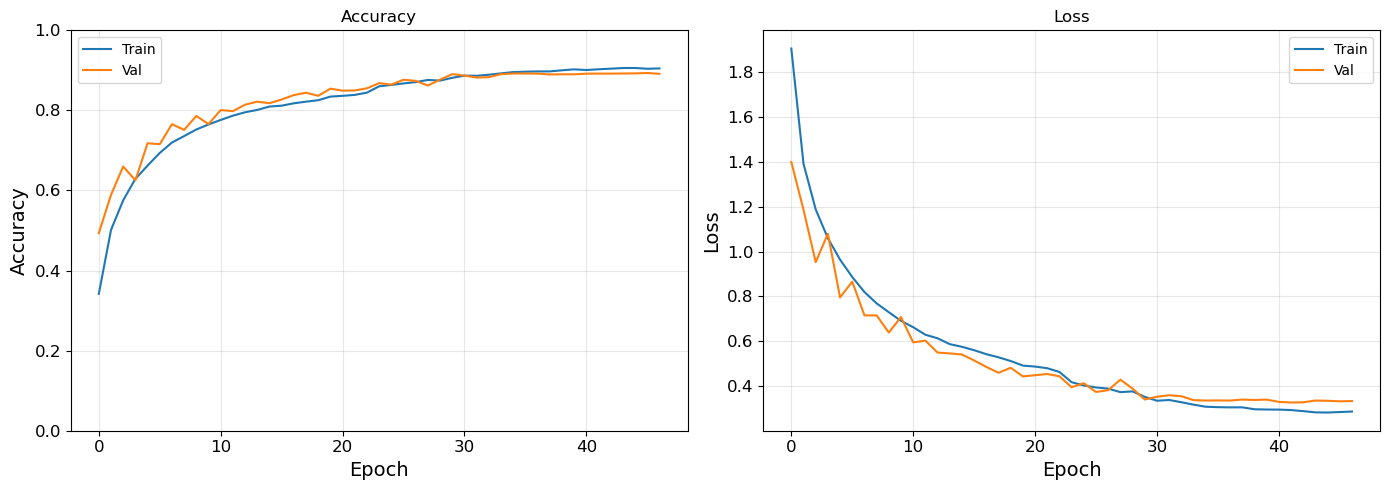

Test Accuracy: 0.8906



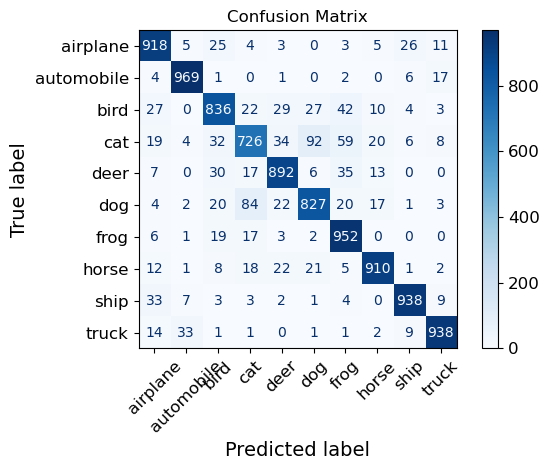

Classification Report:

              precision    recall  f1-score   support

    airplane       0.88      0.92      0.90      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.86      0.84      0.85      1000
         cat       0.81      0.73      0.77      1000
        deer       0.88      0.89      0.89      1000
         dog       0.85      0.83      0.84      1000
        frog       0.85      0.95      0.90      1000
       horse       0.93      0.91      0.92      1000
        ship       0.95      0.94      0.94      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

✅ Metrics saved to saved_models/results2/large/large_metrics.json
Training model: X_large
Training new model: X_large
Summary disabled
Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3116 - loss: 2

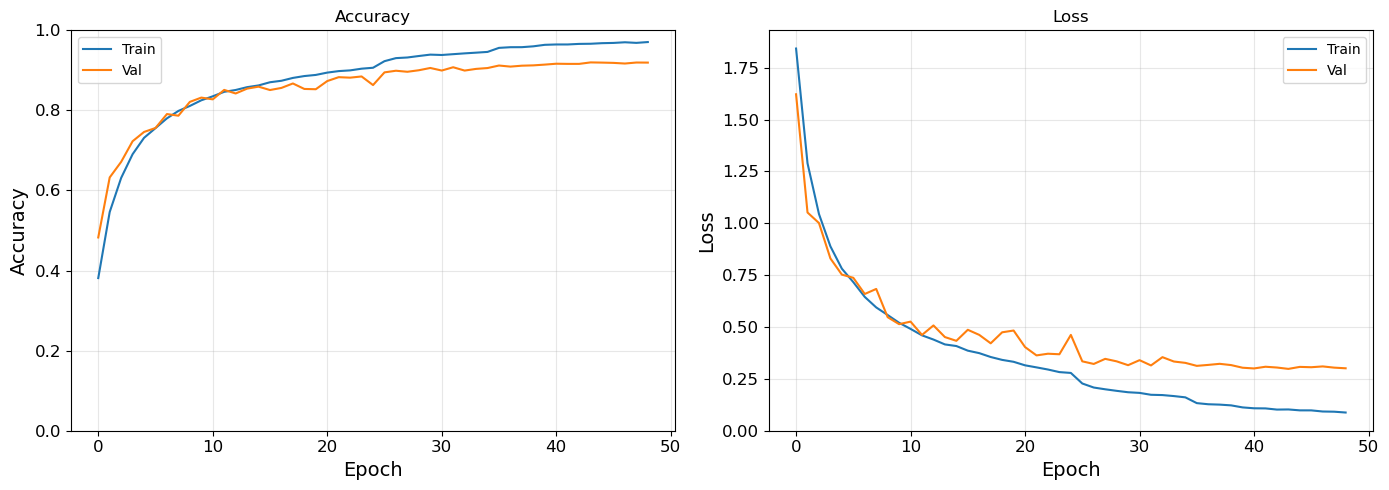

Test Accuracy: 0.9183



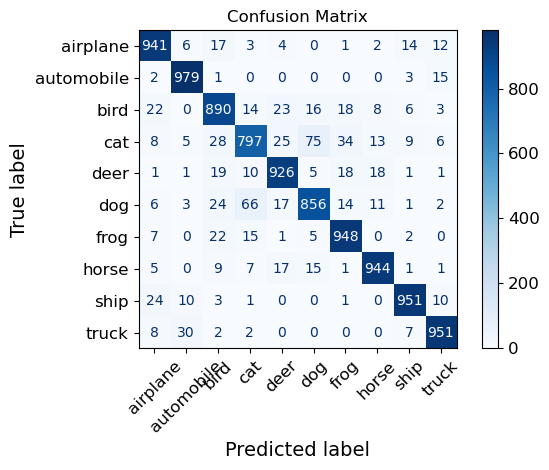

Classification Report:

              precision    recall  f1-score   support

    airplane       0.92      0.94      0.93      1000
  automobile       0.95      0.98      0.96      1000
        bird       0.88      0.89      0.88      1000
         cat       0.87      0.80      0.83      1000
        deer       0.91      0.93      0.92      1000
         dog       0.88      0.86      0.87      1000
        frog       0.92      0.95      0.93      1000
       horse       0.95      0.94      0.95      1000
        ship       0.96      0.95      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

✅ Metrics saved to saved_models/results2/X_large/X_large_metrics.json


In [48]:
results2 = {}

for name in model_names:
    print(f"Training model: {name}")

    save_dir = os.path.join("saved_models", "results2", name)
    os.makedirs(save_dir, exist_ok=True)

    callbacks = get_callbacks(save_dir)
    
    trainer = TrainAndEvaluateModel(
        model_name=name,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=tf.keras.optimizers.Adam(),
        loss_fn="categorical_crossentropy",
        epochs=200,
        callbacks=callbacks,
        X_test=X_test,
        y_test=y_test,
        class_names=classNames,
        force=False,
        base_dir="saved_models/results2"
    )

    results2[name] = trainer.run()


In [49]:
for name, result in results.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")

for name, result in results2.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")



small           | Test Accuracy: 0.7731
medium          | Test Accuracy: 0.7890
large           | Test Accuracy: 0.8191
X_large         | Test Accuracy: 0.8296
small           | Test Accuracy: 0.8339
medium          | Test Accuracy: 0.8508
large           | Test Accuracy: 0.8906
X_large         | Test Accuracy: 0.9183


# Step : GRID search cv on 2 best models


# Step : Define tunable model

Because the 2 best have the same architecture and only the number of parameter per convolution change.
We define a tunable model as follow

In [50]:
def create_flexible_model(filters=(32, 64, 128), 
                          dense_units=128,
                          dropout_rates=None):
    
    if dropout_rates is None:
        dropout_rates = {"block1": 0.1, "block2": 0.2, "block3": 0.3, "dense": 0.5}

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),

        # Block 1 (3 convs + BN + pool + dropout)
        tf.keras.layers.Conv2D(filters[0], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[0], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[0], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(dropout_rates["block1"]),

        # Block 2
        tf.keras.layers.Conv2D(filters[1], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[1], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[1], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(dropout_rates["block2"]),

        # Block 3
        tf.keras.layers.Conv2D(filters[2], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[2], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[2], 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(dropout_rates["block3"]),

        # Dense head
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rates["dense"]),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

    return model


# Step : Define new TrainAndEvaluationModel Class

In [ ]:
import json
import tensorflow as tf
from types import SimpleNamespace

class TrainAndEvaluateModel:
    def __init__(self, model_name="flexible",
                 train_ds=None, 
                 val_ds=None,
                 optimizer=None, 
                 loss_fn=None, 
                 epochs=5,
                 callbacks=None,
                 X_test=None, 
                 y_test=None, 
                 class_names=None,
                 filters=(32, 64, 128),
                 dense_units=128,
                 dropout_rates=None,
                 force=False,
                 model_summary=False,
                 base_dir="saved_models"
                 ):
        
        self.model_name = model_name
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.callbacks = callbacks
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.filters = filters
        self.dense_units = dense_units
        self.dropout_rates = dropout_rates
        self.force = force
        self.model_summary = model_summary

        self.save_dir = os.path.join(base_dir, self.model_name)
        os.makedirs(self.save_dir, exist_ok=True)

        # Paths
        self.save_path = os.path.join(self.save_dir, f"{self.model_name}_model.keras")
        self.history_path = os.path.join(self.save_dir, f"{self.model_name}_history.json")
        self.metrics_path = os.path.join(self.save_dir, f"{self.model_name}_metrics.json")
        self.best_weights_path = os.path.join(self.save_dir, "best_model.weights.h5")

        self.model = None
        self.history = None
        self.metrics = None

    def train_model(self):
        # Case 1: Resume from best weights if they exist
        if os.path.exists(self.best_weights_path) and not self.force:
            print(f"Resuming from best checkpoint: {self.best_weights_path}")
            self.model = create_flexible_model(
                filters=self.filters,
                dense_units=self.dense_units,
                dropout_rates=self.dropout_rates
            )
            self.model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
            self.model.load_weights(self.best_weights_path)

            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Case 2: Resume from last full model
        elif os.path.exists(self.save_path) and not self.force:
            print(f"Loading last trained model: {self.save_path}")
            self.model = tf.keras.models.load_model(self.save_path)
            self.model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])

            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Case 3: Train from scratch
        else:
            if self.force:
                print(f"Forcing retrain for model: {self.model_name}")
            else:
                print(f"Training new model: {self.model_name}")

            self.model = create_flexible_model(
                filters=self.filters,
                dense_units=self.dense_units,
                dropout_rates=self.dropout_rates
            )
            self.model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])

            if self.model_summary:
                print(f"Summary for model: {self.model_name}")
                self.model.summary()
            else:
                print("Summary disabled")

            fit_kwargs = {
                "x": self.train_ds,
                "epochs": self.epochs,
                "verbose": 1,
                "validation_data": self.val_ds
            }
            if self.callbacks is not None:
                fit_kwargs["callbacks"] = self.callbacks

            self.history = self.model.fit(**fit_kwargs)

            # Save last full model
            self.model.save(self.save_path)
            print(f"Last model saved to {self.save_path}")

            with open(self.history_path, "w") as f:
                json.dump(self.history.history, f)
            print(f"History saved to {self.history_path}")

        return self.model, self.history

    def load_best_weights(self):
        if os.path.exists(self.best_weights_path):
            print(f"Loading best weights from {self.best_weights_path}")
            best_model = create_flexible_model(
                filters=self.filters,
                dense_units=self.dense_units,
                dropout_rates=self.dropout_rates
            )
            best_model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
            best_model.load_weights(self.best_weights_path)
            self.model = best_model
        else:
            print("No best_model.weights.h5 found, using current model.")

    def evaluate_model(self):
        # Always compute a baseline test metric via Keras
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        metrics = {"test_loss": float(test_loss), "test_accuracy": float(test_acc)}

        # Optionally augment with your custom report if available
        try:
            extra = evaluate_and_report(
                self.model,
                self.X_test,
                self.y_test,
                class_names=self.class_names
            )
            if isinstance(extra, dict):
                # don't clobber guaranteed keys
                for k, v in extra.items():
                    if k not in metrics:
                        metrics[k] = v
        except Exception as e:
            print(f"Note: evaluate_and_report skipped ({e}).")

        self.metrics = metrics

        # Save metrics next to this experiment
        with open(self.metrics_path, "w") as f:
            json.dump(self.metrics, f)
        print(f"Metrics saved to {self.metrics_path}")

        return self.metrics

    def run(self):
        self.train_model()
        self.load_best_weights()
        self.evaluate_model()
        return {
            "model": self.model,
            "history": self.history,
            "metrics": self.metrics
        }
    
def _opt_tag(p):
    name = str(p.get("optimizer", "adam")).lower()
    if name == "sgd":
        m = p.get("momentum", 0.0)
        n = "n1" if p.get("nesterov", False) else "n0"
        return f"sgd_m{m}_{n}"
    return name

def _exp_name_from_params(p):
    f1, f2, f3 = p["filters"]
    dr = p["dropout_rates"]
    def _fmt_lr(x):
        try:
            return f"{float(x):.0e}" if float(x) < 1e-2 else str(x).replace('.', 'p')
        except Exception:
            return str(x).replace('.', 'p')
    return (
        f"f{f1}-{f2}-{f3}"
        f"__dense{p['dense_units']}"
        f"__dr{dr['block1']}-{dr['block2']}-{dr['block3']}-{dr['dense']}"
        f"__opt{_opt_tag(p)}"
        f"__lr{_fmt_lr(p['lr'])}"
        f"__bs{p['batch_size']}"
        f"__lrp{p['lr_patience']}"
        f"__minlr{_fmt_lr(p['min_lr'])}"
    ).replace('.', '')

def _build_optimizer(params):
    name = str(params.get("optimizer", "adam")).lower()
    lr = float(params.get("lr", 1e-3))
    if name == "sgd":
        momentum = float(params.get("momentum", 0.9))
        nesterov = bool(params.get("nesterov", False))
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    elif name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError(f"Unknown optimizer: {name}")


# Step : Define the param for the search and the range

In [53]:
param_grid = {
    "filters": [
        #(32, 64, 128),   # like "large"
        (64, 128, 256),   # like "X_large"
        (128, 128, 256)  # like "XX_large"
    ],
    "dense_units": [256],
    "dropout_rates": [
        {"block1":0.1, "block2":0.2, "block3":0.3, "dense":0.5}
        ,{"block1":0.15, "block2":0.25, "block3":0.35, "dense":0.6}
        ,{"block1":0.15, "block2":0.25, "block3":0.35, "dense":0.7}
    ],

    "optimizer": ["adam", "sgd"],
    "momentum": [0.9],
    "nesterov": [True, False], 

    "lr": [1e-2,1e-3],
    "batch_size": [64],

    "lr_patience": [2],
    "min_lr": [1e-7]
}


In [ ]:
def simple_grid_search(param_grid,
                       X_train_new, y_train_new,
                       X_val, y_val,
                       X_test, y_test,
                       classNames,
                       augment,
                       epochs=30):

    results = []
    BASE_DIR = os.path.join("saved_models", "resultgrid")
    os.makedirs(BASE_DIR, exist_ok=True)

    keys, values = zip(*param_grid.items())
    for combo in itertools.product(*values):
        params = dict(zip(keys, combo))
        exp_name = _exp_name_from_params(params)
        save_dir = os.path.join(BASE_DIR, exp_name)
        os.makedirs(save_dir, exist_ok=True)
        print(f"\n🔍 Testing {params}\n→ Saving to: {save_dir}\n")

        train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
                    .shuffle(10000)
                    .batch(params["batch_size"])
                    .map(lambda x, y: (augment(x, training=True), y),
                         num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))
        val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                  .batch(params["batch_size"])
                  .prefetch(tf.data.AUTOTUNE))

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                                 patience=params["lr_patience"], min_lr=params["min_lr"], verbose=1),
            tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, "best_model.weights.h5"),
                                               monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1)
        ]

        opt = _build_optimizer(params)

        trainer = TrainAndEvaluateModel(
            model_name=exp_name,
            train_ds=train_ds,
            val_ds=val_ds,
            optimizer=opt,
            loss_fn="categorical_crossentropy",
            epochs=epochs,
            callbacks=callbacks,
            X_test=X_test,
            y_test=y_test,
            class_names=classNames,
            filters=params["filters"],
            dense_units=params["dense_units"],
            dropout_rates=params["dropout_rates"],
            force=True,
            base_dir=BASE_DIR
        )

        res = trainer.run()

        hist_dict = res["history"].history if hasattr(res["history"], "history") else {}
        val_acc_list = hist_dict.get("val_accuracy") or hist_dict.get("val_acc") or []
        val_acc = max(val_acc_list) if len(val_acc_list) else float("nan")

        metrics = res.get("metrics") or {}
        test_acc = (metrics.get("test_accuracy") or metrics.get("accuracy") or metrics.get("test_acc"))
        if test_acc is None:
            _, test_acc = res["model"].evaluate(X_test, y_test, verbose=0)

        results.append({
            **params,
            "save_dir": save_dir,
            "val_acc": float(val_acc),
            "test_acc": float(test_acc)
        })

    return pd.DataFrame(results)


# Step : Run grid_search ()


🔍 Testing {'filters': (64, 128, 256), 'dense_units': 256, 'dropout_rates': {'block1': 0.1, 'block2': 0.2, 'block3': 0.3, 'dense': 0.5}, 'optimizer': 'adam', 'momentum': 0.9, 'nesterov': True, 'lr': 0.01, 'batch_size': 64, 'lr_patience': 2, 'min_lr': 1e-07}
→ Saving to: saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07

Forcing retrain for model: f64-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07
Summary disabled
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2652 - loss: 2.2870
Epoch 1: val_loss improved from None to 2.43383, saving model to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - accuracy: 0.3037 - loss: 2.0574 - val_accuracy: 0.2739 - val_loss: 2.4338 - learning_rate: 0.0100
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4163 - loss: 1.591

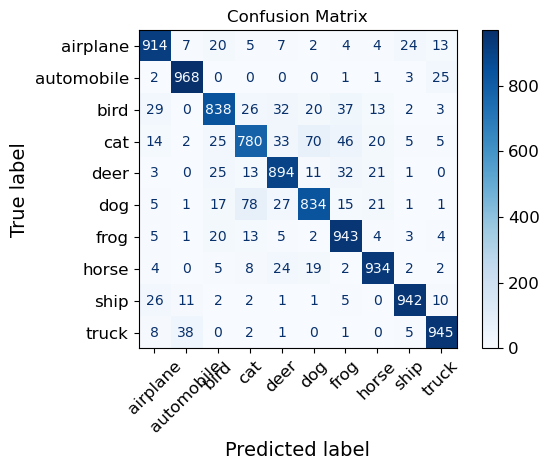

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.91      0.91      1000
  automobile       0.94      0.97      0.95      1000
        bird       0.88      0.84      0.86      1000
         cat       0.84      0.78      0.81      1000
        deer       0.87      0.89      0.88      1000
         dog       0.87      0.83      0.85      1000
        frog       0.87      0.94      0.90      1000
       horse       0.92      0.93      0.93      1000
        ship       0.95      0.94      0.95      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json

🔍 Test

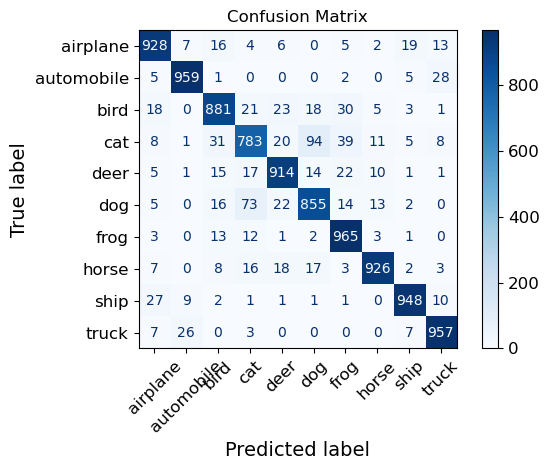

Classification Report:

              precision    recall  f1-score   support

    airplane       0.92      0.93      0.92      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.90      0.88      0.89      1000
         cat       0.84      0.78      0.81      1000
        deer       0.91      0.91      0.91      1000
         dog       0.85      0.85      0.85      1000
        frog       0.89      0.96      0.93      1000
       horse       0.95      0.93      0.94      1000
        ship       0.95      0.95      0.95      1000
       truck       0.94      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

🔍 Te

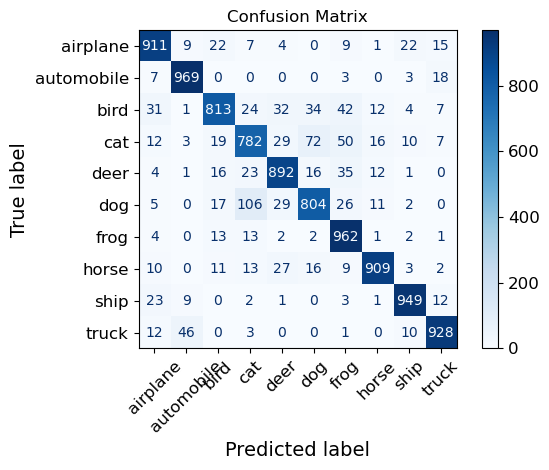

Classification Report:

              precision    recall  f1-score   support

    airplane       0.89      0.91      0.90      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.89      0.81      0.85      1000
         cat       0.80      0.78      0.79      1000
        deer       0.88      0.89      0.88      1000
         dog       0.85      0.80      0.83      1000
        frog       0.84      0.96      0.90      1000
       horse       0.94      0.91      0.93      1000
        ship       0.94      0.95      0.95      1000
       truck       0.94      0.93      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json

🔍 Test

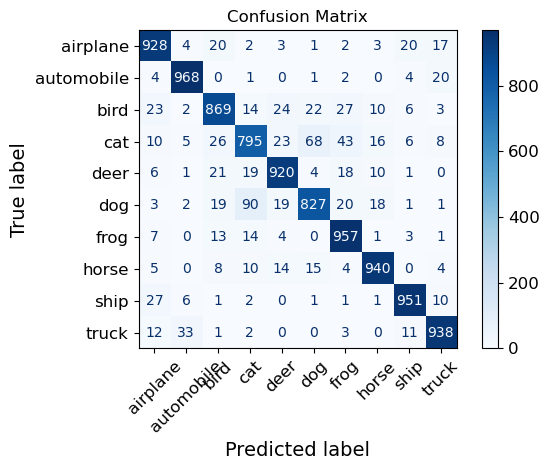

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.89      0.87      0.88      1000
         cat       0.84      0.80      0.82      1000
        deer       0.91      0.92      0.92      1000
         dog       0.88      0.83      0.85      1000
        frog       0.89      0.96      0.92      1000
       horse       0.94      0.94      0.94      1000
        ship       0.95      0.95      0.95      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

🔍 Te

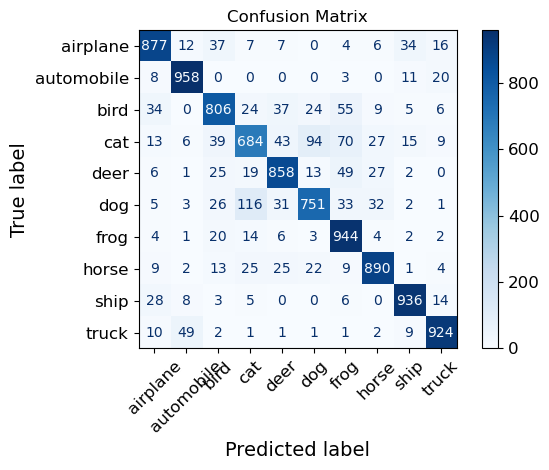

Classification Report:

              precision    recall  f1-score   support

    airplane       0.88      0.88      0.88      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.83      0.81      0.82      1000
         cat       0.76      0.68      0.72      1000
        deer       0.85      0.86      0.85      1000
         dog       0.83      0.75      0.79      1000
        frog       0.80      0.94      0.87      1000
       horse       0.89      0.89      0.89      1000
        ship       0.92      0.94      0.93      1000
       truck       0.93      0.92      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07_metrics.

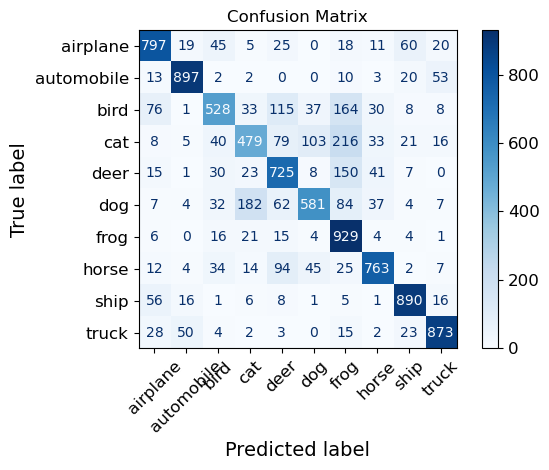

Classification Report:

              precision    recall  f1-score   support

    airplane       0.78      0.80      0.79      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.72      0.53      0.61      1000
         cat       0.62      0.48      0.54      1000
        deer       0.64      0.72      0.68      1000
         dog       0.75      0.58      0.65      1000
        frog       0.57      0.93      0.71      1000
       horse       0.82      0.76      0.79      1000
        ship       0.86      0.89      0.87      1000
       truck       0.87      0.87      0.87      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07_metric

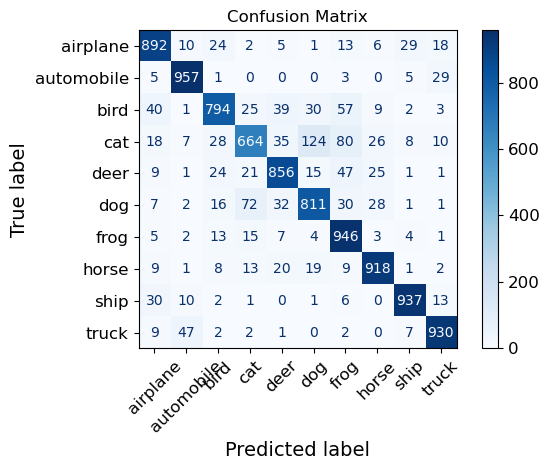

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.89      0.88      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.87      0.79      0.83      1000
         cat       0.81      0.66      0.73      1000
        deer       0.86      0.86      0.86      1000
         dog       0.81      0.81      0.81      1000
        frog       0.79      0.95      0.86      1000
       horse       0.90      0.92      0.91      1000
        ship       0.94      0.94      0.94      1000
       truck       0.92      0.93      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07_metrics.

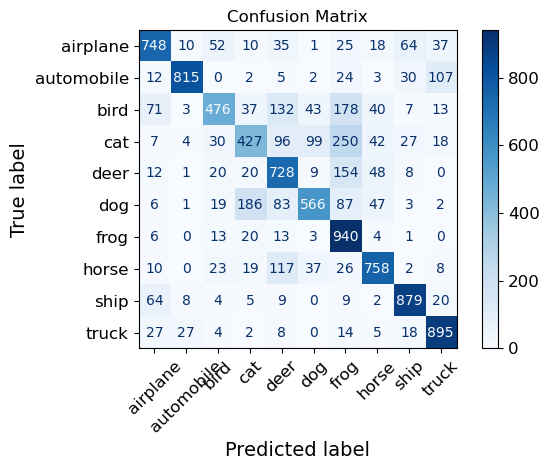

Classification Report:

              precision    recall  f1-score   support

    airplane       0.78      0.75      0.76      1000
  automobile       0.94      0.81      0.87      1000
        bird       0.74      0.48      0.58      1000
         cat       0.59      0.43      0.49      1000
        deer       0.59      0.73      0.65      1000
         dog       0.74      0.57      0.64      1000
        frog       0.55      0.94      0.69      1000
       horse       0.78      0.76      0.77      1000
        ship       0.85      0.88      0.86      1000
       truck       0.81      0.90      0.85      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07_metric

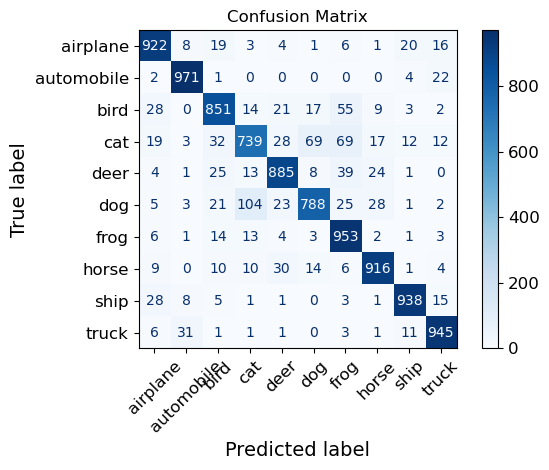

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.87      0.85      0.86      1000
         cat       0.82      0.74      0.78      1000
        deer       0.89      0.89      0.89      1000
         dog       0.88      0.79      0.83      1000
        frog       0.82      0.95      0.88      1000
       horse       0.92      0.92      0.92      1000
        ship       0.95      0.94      0.94      1000
       truck       0.93      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json



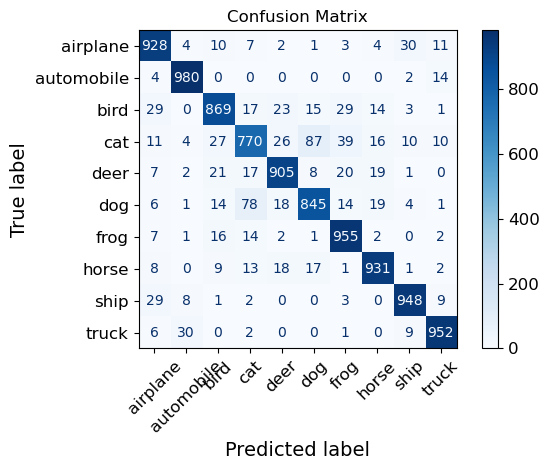

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.93      0.91      1000
  automobile       0.95      0.98      0.97      1000
        bird       0.90      0.87      0.88      1000
         cat       0.84      0.77      0.80      1000
        deer       0.91      0.91      0.91      1000
         dog       0.87      0.84      0.86      1000
        frog       0.90      0.95      0.92      1000
       horse       0.93      0.93      0.93      1000
        ship       0.94      0.95      0.94      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

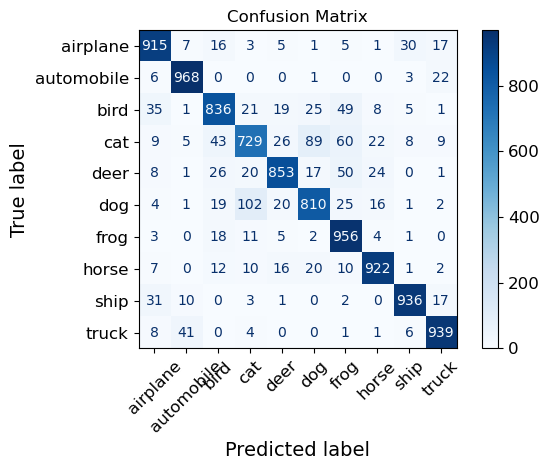

Classification Report:

              precision    recall  f1-score   support

    airplane       0.89      0.92      0.90      1000
  automobile       0.94      0.97      0.95      1000
        bird       0.86      0.84      0.85      1000
         cat       0.81      0.73      0.77      1000
        deer       0.90      0.85      0.88      1000
         dog       0.84      0.81      0.82      1000
        frog       0.83      0.96      0.89      1000
       horse       0.92      0.92      0.92      1000
        ship       0.94      0.94      0.94      1000
       truck       0.93      0.94      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json



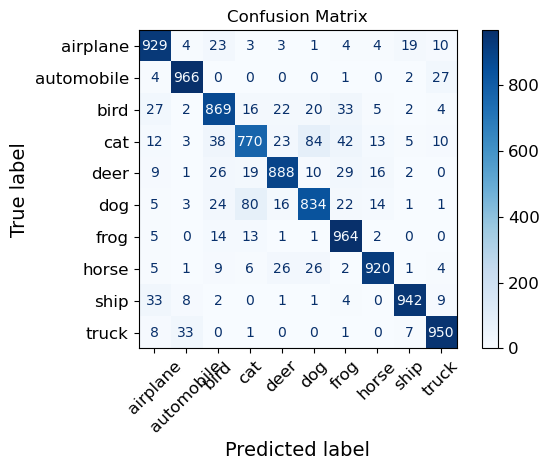

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.93      0.91      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.86      0.87      0.87      1000
         cat       0.85      0.77      0.81      1000
        deer       0.91      0.89      0.90      1000
         dog       0.85      0.83      0.84      1000
        frog       0.87      0.96      0.92      1000
       horse       0.94      0.92      0.93      1000
        ship       0.96      0.94      0.95      1000
       truck       0.94      0.95      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

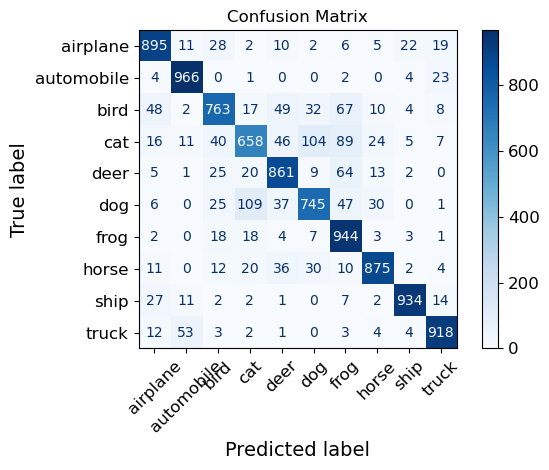

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.90      0.88      1000
  automobile       0.92      0.97      0.94      1000
        bird       0.83      0.76      0.80      1000
         cat       0.78      0.66      0.71      1000
        deer       0.82      0.86      0.84      1000
         dog       0.80      0.74      0.77      1000
        frog       0.76      0.94      0.84      1000
       horse       0.91      0.88      0.89      1000
        ship       0.95      0.93      0.94      1000
       truck       0.92      0.92      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07_me

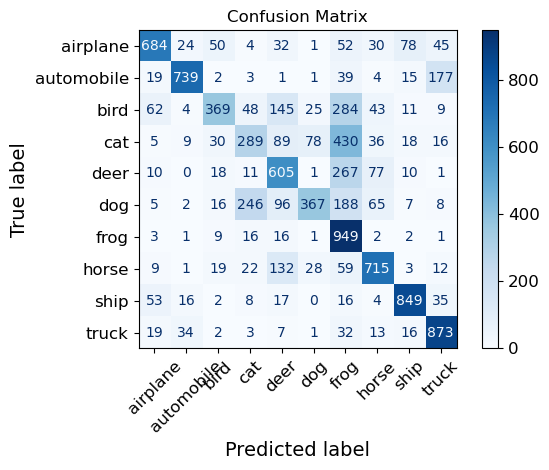

Classification Report:

              precision    recall  f1-score   support

    airplane       0.79      0.68      0.73      1000
  automobile       0.89      0.74      0.81      1000
        bird       0.71      0.37      0.49      1000
         cat       0.44      0.29      0.35      1000
        deer       0.53      0.60      0.57      1000
         dog       0.73      0.37      0.49      1000
        frog       0.41      0.95      0.57      1000
       horse       0.72      0.71      0.72      1000
        ship       0.84      0.85      0.85      1000
       truck       0.74      0.87      0.80      1000

    accuracy                           0.64     10000
   macro avg       0.68      0.64      0.64     10000
weighted avg       0.68      0.64      0.64     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07_

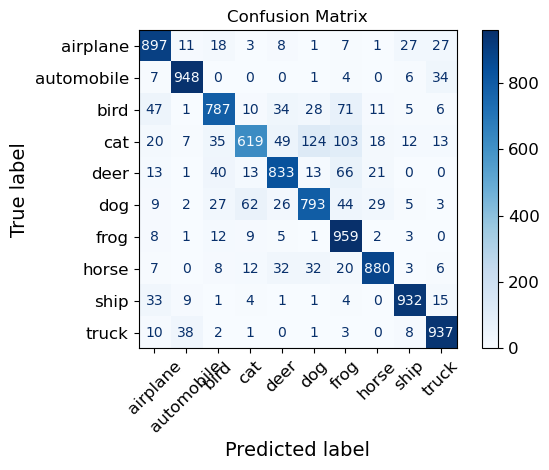

Classification Report:

              precision    recall  f1-score   support

    airplane       0.85      0.90      0.87      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.85      0.79      0.82      1000
         cat       0.84      0.62      0.71      1000
        deer       0.84      0.83      0.84      1000
         dog       0.80      0.79      0.79      1000
        frog       0.75      0.96      0.84      1000
       horse       0.91      0.88      0.90      1000
        ship       0.93      0.93      0.93      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07_me

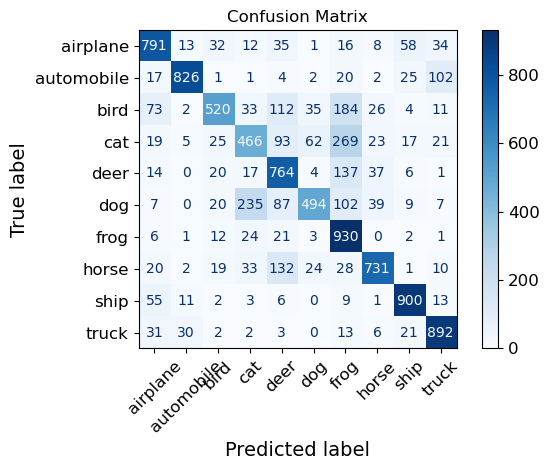

Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.79      0.78      1000
  automobile       0.93      0.83      0.87      1000
        bird       0.80      0.52      0.63      1000
         cat       0.56      0.47      0.51      1000
        deer       0.61      0.76      0.68      1000
         dog       0.79      0.49      0.61      1000
        frog       0.54      0.93      0.69      1000
       horse       0.84      0.73      0.78      1000
        ship       0.86      0.90      0.88      1000
       truck       0.82      0.89      0.85      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-06__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07_

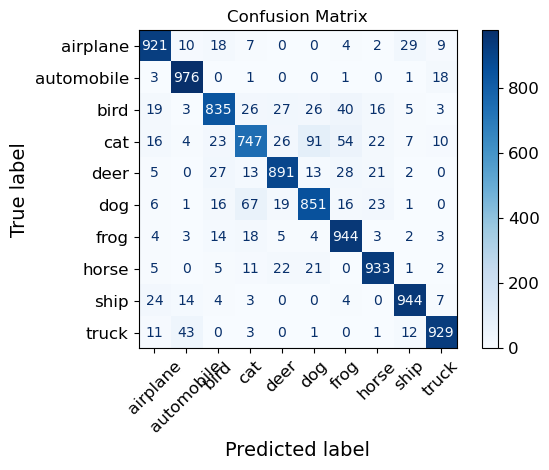

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.92      0.91      1000
  automobile       0.93      0.98      0.95      1000
        bird       0.89      0.83      0.86      1000
         cat       0.83      0.75      0.79      1000
        deer       0.90      0.89      0.90      1000
         dog       0.85      0.85      0.85      1000
        frog       0.87      0.94      0.90      1000
       horse       0.91      0.93      0.92      1000
        ship       0.94      0.94      0.94      1000
       truck       0.95      0.93      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optadam__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json



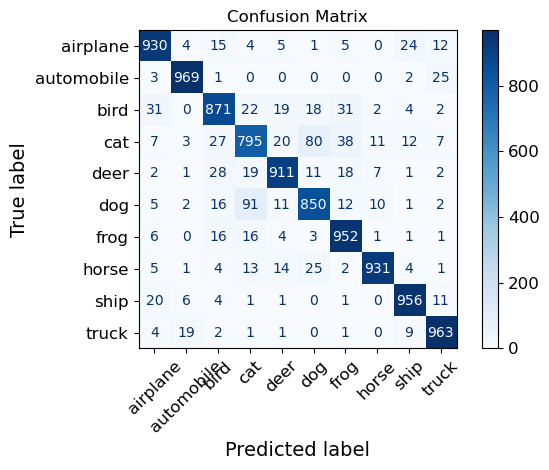

Classification Report:

              precision    recall  f1-score   support

    airplane       0.92      0.93      0.92      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.89      0.87      0.88      1000
         cat       0.83      0.80      0.81      1000
        deer       0.92      0.91      0.92      1000
         dog       0.86      0.85      0.86      1000
        frog       0.90      0.95      0.92      1000
       horse       0.97      0.93      0.95      1000
        ship       0.94      0.96      0.95      1000
       truck       0.94      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

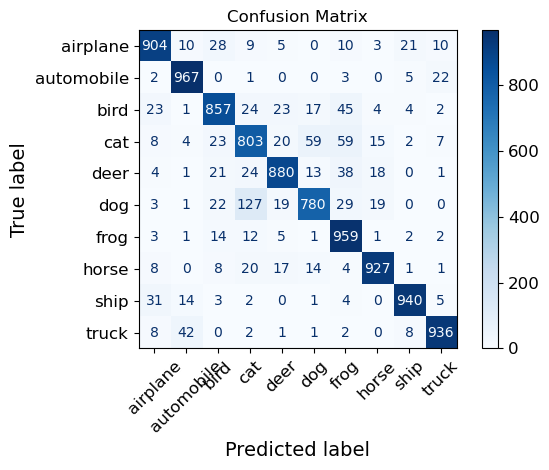

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.90      0.91      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.88      0.86      0.87      1000
         cat       0.78      0.80      0.79      1000
        deer       0.91      0.88      0.89      1000
         dog       0.88      0.78      0.83      1000
        frog       0.83      0.96      0.89      1000
       horse       0.94      0.93      0.93      1000
        ship       0.96      0.94      0.95      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optadam__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json



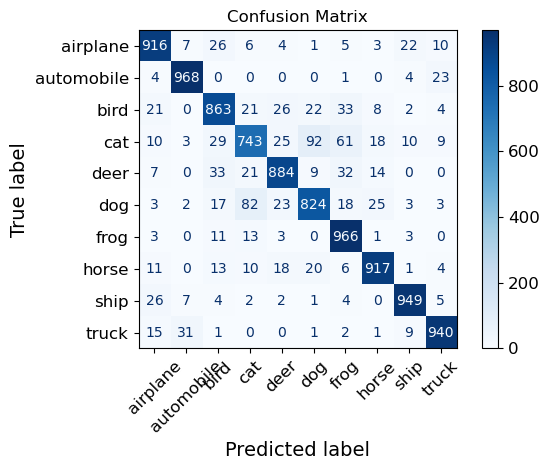

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.87      0.86      0.86      1000
         cat       0.83      0.74      0.78      1000
        deer       0.90      0.88      0.89      1000
         dog       0.85      0.82      0.84      1000
        frog       0.86      0.97      0.91      1000
       horse       0.93      0.92      0.92      1000
        ship       0.95      0.95      0.95      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

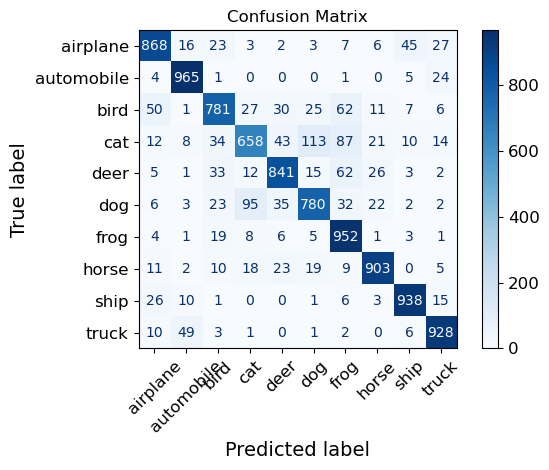

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.87      0.87      1000
  automobile       0.91      0.96      0.94      1000
        bird       0.84      0.78      0.81      1000
         cat       0.80      0.66      0.72      1000
        deer       0.86      0.84      0.85      1000
         dog       0.81      0.78      0.80      1000
        frog       0.78      0.95      0.86      1000
       horse       0.91      0.90      0.91      1000
        ship       0.92      0.94      0.93      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07_me

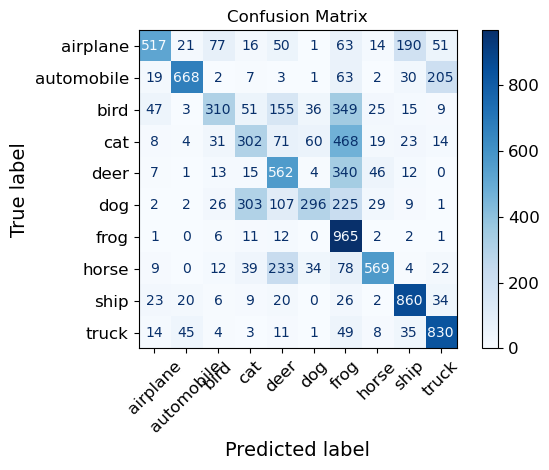

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.52      0.63      1000
  automobile       0.87      0.67      0.76      1000
        bird       0.64      0.31      0.42      1000
         cat       0.40      0.30      0.34      1000
        deer       0.46      0.56      0.51      1000
         dog       0.68      0.30      0.41      1000
        frog       0.37      0.96      0.53      1000
       horse       0.79      0.57      0.66      1000
        ship       0.73      0.86      0.79      1000
       truck       0.71      0.83      0.77      1000

    accuracy                           0.59     10000
   macro avg       0.65      0.59      0.58     10000
weighted avg       0.65      0.59      0.58     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07_

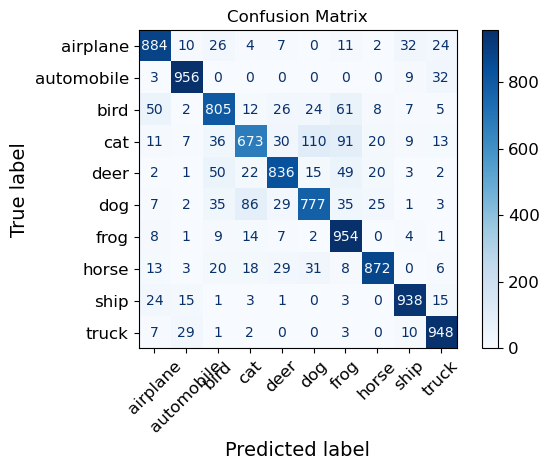

Classification Report:

              precision    recall  f1-score   support

    airplane       0.88      0.88      0.88      1000
  automobile       0.93      0.96      0.94      1000
        bird       0.82      0.81      0.81      1000
         cat       0.81      0.67      0.73      1000
        deer       0.87      0.84      0.85      1000
         dog       0.81      0.78      0.79      1000
        frog       0.79      0.95      0.86      1000
       horse       0.92      0.87      0.90      1000
        ship       0.93      0.94      0.93      1000
       truck       0.90      0.95      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07_me

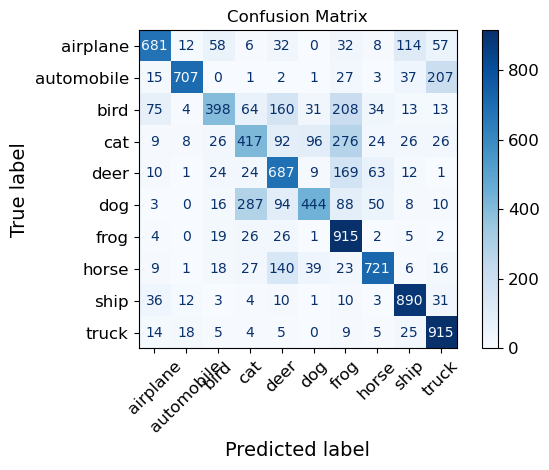

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.68      0.73      1000
  automobile       0.93      0.71      0.80      1000
        bird       0.70      0.40      0.51      1000
         cat       0.48      0.42      0.45      1000
        deer       0.55      0.69      0.61      1000
         dog       0.71      0.44      0.55      1000
        frog       0.52      0.92      0.66      1000
       horse       0.79      0.72      0.75      1000
        ship       0.78      0.89      0.83      1000
       truck       0.72      0.92      0.80      1000

    accuracy                           0.68     10000
   macro avg       0.70      0.68      0.67     10000
weighted avg       0.70      0.68      0.67     10000

Metrics saved to saved_models/resultgrid/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07/f64-128-256__dense256__dr015-025-035-07__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07_

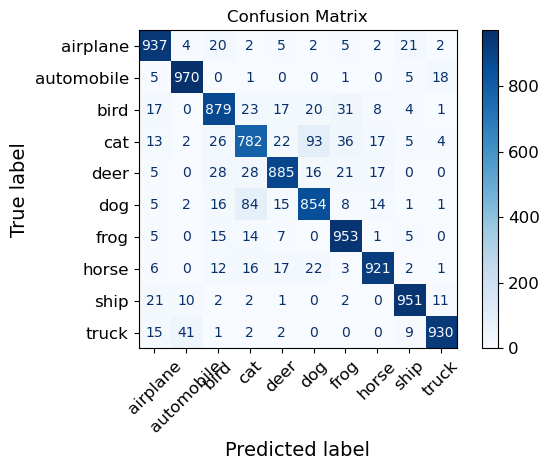

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.94      0.92      1000
  automobile       0.94      0.97      0.96      1000
        bird       0.88      0.88      0.88      1000
         cat       0.82      0.78      0.80      1000
        deer       0.91      0.89      0.90      1000
         dog       0.85      0.85      0.85      1000
        frog       0.90      0.95      0.93      1000
       horse       0.94      0.92      0.93      1000
        ship       0.95      0.95      0.95      1000
       truck       0.96      0.93      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json

🔍 Te

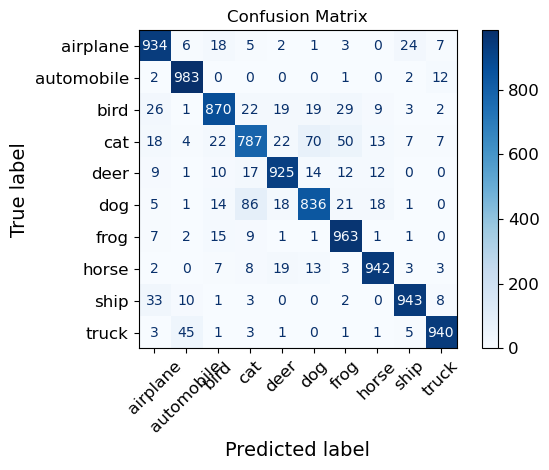

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.93      0.92      1000
  automobile       0.93      0.98      0.96      1000
        bird       0.91      0.87      0.89      1000
         cat       0.84      0.79      0.81      1000
        deer       0.92      0.93      0.92      1000
         dog       0.88      0.84      0.86      1000
        frog       0.89      0.96      0.92      1000
       horse       0.95      0.94      0.94      1000
        ship       0.95      0.94      0.95      1000
       truck       0.96      0.94      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

🔍 

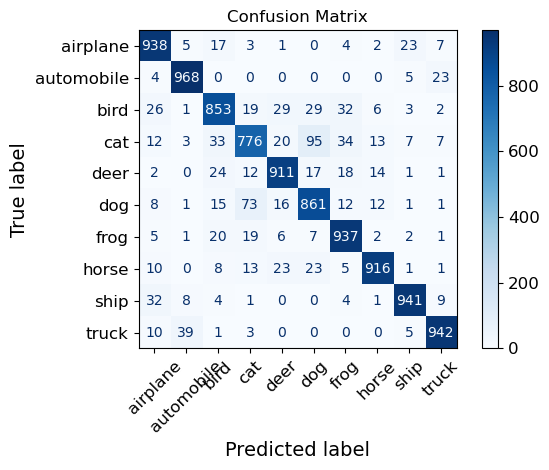

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.94      0.92      1000
  automobile       0.94      0.97      0.96      1000
        bird       0.87      0.85      0.86      1000
         cat       0.84      0.78      0.81      1000
        deer       0.91      0.91      0.91      1000
         dog       0.83      0.86      0.85      1000
        frog       0.90      0.94      0.92      1000
       horse       0.95      0.92      0.93      1000
        ship       0.95      0.94      0.95      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json

🔍 Te

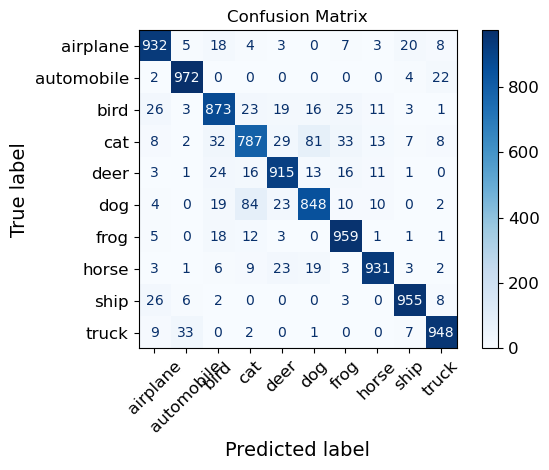

Classification Report:

              precision    recall  f1-score   support

    airplane       0.92      0.93      0.92      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.88      0.87      0.88      1000
         cat       0.84      0.79      0.81      1000
        deer       0.90      0.92      0.91      1000
         dog       0.87      0.85      0.86      1000
        frog       0.91      0.96      0.93      1000
       horse       0.95      0.93      0.94      1000
        ship       0.95      0.95      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.json

🔍 

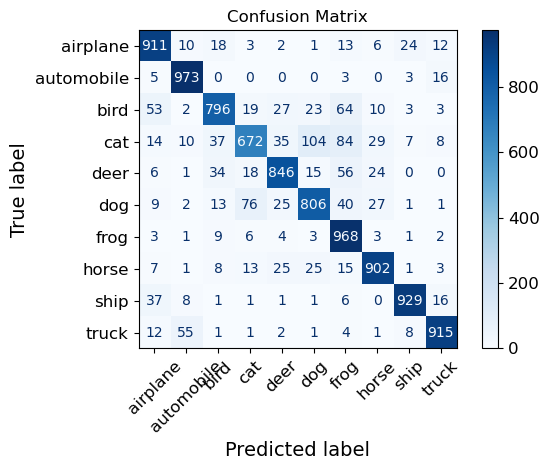

Classification Report:

              precision    recall  f1-score   support

    airplane       0.86      0.91      0.89      1000
  automobile       0.92      0.97      0.94      1000
        bird       0.87      0.80      0.83      1000
         cat       0.83      0.67      0.74      1000
        deer       0.87      0.85      0.86      1000
         dog       0.82      0.81      0.81      1000
        frog       0.77      0.97      0.86      1000
       horse       0.90      0.90      0.90      1000
        ship       0.95      0.93      0.94      1000
       truck       0.94      0.92      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07_metric

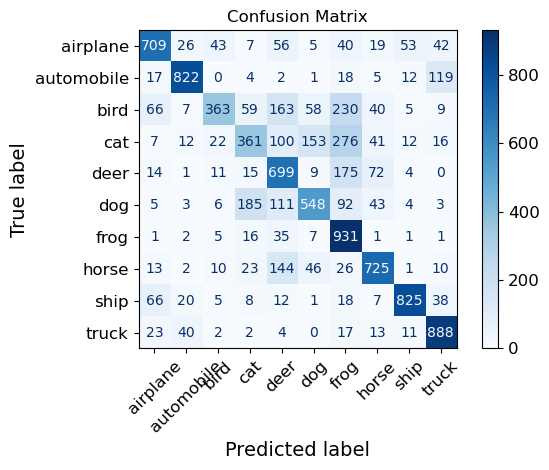

Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.71      0.74      1000
  automobile       0.88      0.82      0.85      1000
        bird       0.78      0.36      0.49      1000
         cat       0.53      0.36      0.43      1000
        deer       0.53      0.70      0.60      1000
         dog       0.66      0.55      0.60      1000
        frog       0.51      0.93      0.66      1000
       horse       0.75      0.72      0.74      1000
        ship       0.89      0.82      0.86      1000
       truck       0.79      0.89      0.84      1000

    accuracy                           0.69     10000
   macro avg       0.71      0.69      0.68     10000
weighted avg       0.71      0.69      0.68     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07_metr

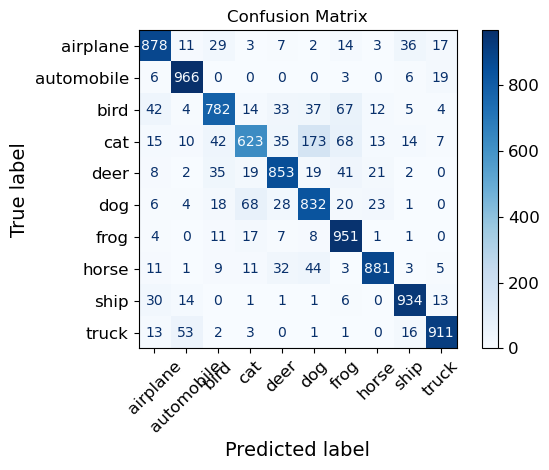

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.88      0.87      1000
  automobile       0.91      0.97      0.94      1000
        bird       0.84      0.78      0.81      1000
         cat       0.82      0.62      0.71      1000
        deer       0.86      0.85      0.85      1000
         dog       0.74      0.83      0.79      1000
        frog       0.81      0.95      0.87      1000
       horse       0.92      0.88      0.90      1000
        ship       0.92      0.93      0.93      1000
       truck       0.93      0.91      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07_metric

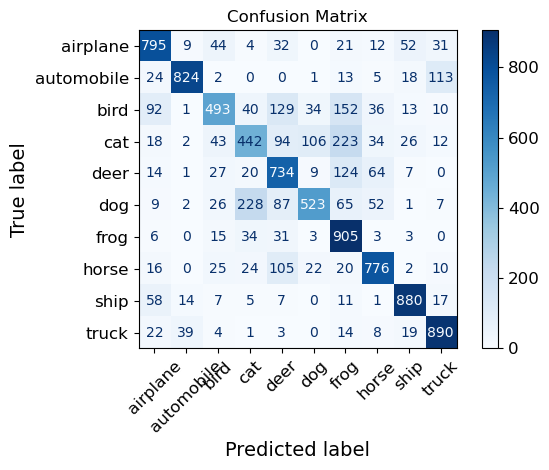

Classification Report:

              precision    recall  f1-score   support

    airplane       0.75      0.80      0.77      1000
  automobile       0.92      0.82      0.87      1000
        bird       0.72      0.49      0.58      1000
         cat       0.55      0.44      0.49      1000
        deer       0.60      0.73      0.66      1000
         dog       0.75      0.52      0.62      1000
        frog       0.58      0.91      0.71      1000
       horse       0.78      0.78      0.78      1000
        ship       0.86      0.88      0.87      1000
       truck       0.82      0.89      0.85      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr01-02-03-05__optsgd_m09_n0__lr1e-03__bs64__lrp2__minlr1e-07_metr

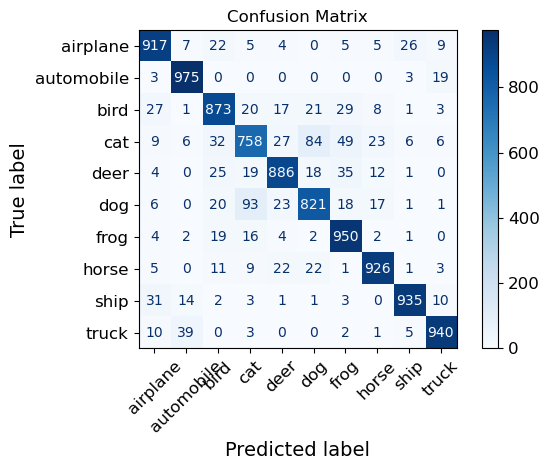

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.87      0.87      0.87      1000
         cat       0.82      0.76      0.79      1000
        deer       0.90      0.89      0.89      1000
         dog       0.85      0.82      0.83      1000
        frog       0.87      0.95      0.91      1000
       horse       0.93      0.93      0.93      1000
        ship       0.95      0.94      0.94      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json

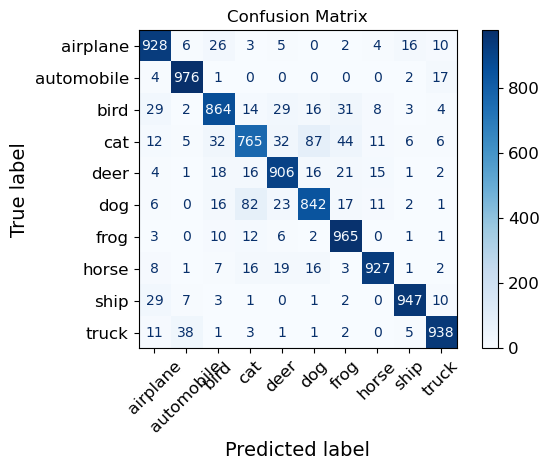

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.93      0.91      1000
  automobile       0.94      0.98      0.96      1000
        bird       0.88      0.86      0.87      1000
         cat       0.84      0.77      0.80      1000
        deer       0.89      0.91      0.90      1000
         dog       0.86      0.84      0.85      1000
        frog       0.89      0.96      0.92      1000
       horse       0.95      0.93      0.94      1000
        ship       0.96      0.95      0.95      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.js

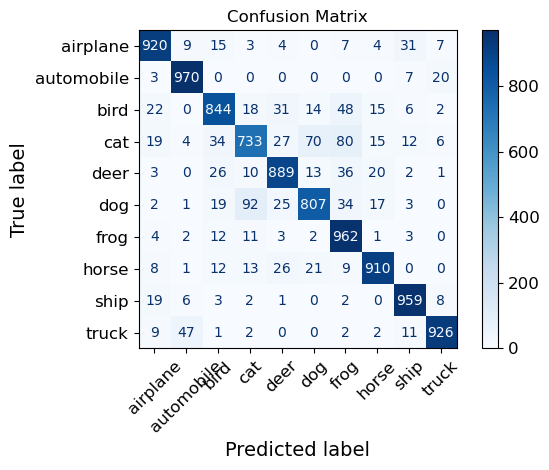

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.92      0.92      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.87      0.84      0.86      1000
         cat       0.83      0.73      0.78      1000
        deer       0.88      0.89      0.89      1000
         dog       0.87      0.81      0.84      1000
        frog       0.82      0.96      0.88      1000
       horse       0.92      0.91      0.92      1000
        ship       0.93      0.96      0.94      1000
       truck       0.95      0.93      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr015-025-035-06__optadam__lr0p01__bs64__lrp2__minlr1e-07_metrics.json

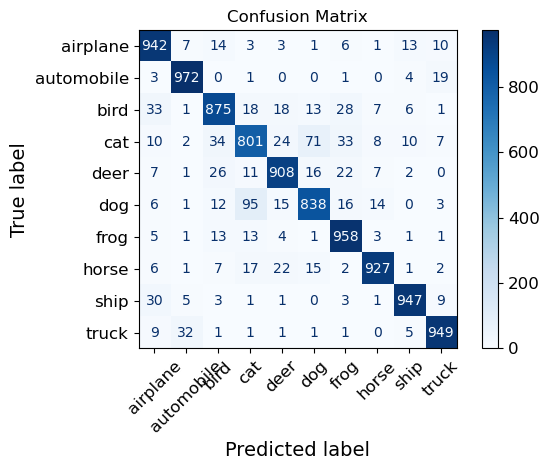

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.94      0.92      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.89      0.88      0.88      1000
         cat       0.83      0.80      0.82      1000
        deer       0.91      0.91      0.91      1000
         dog       0.88      0.84      0.86      1000
        frog       0.90      0.96      0.93      1000
       horse       0.96      0.93      0.94      1000
        ship       0.96      0.95      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr015-025-035-06__optadam__lr1e-03__bs64__lrp2__minlr1e-07_metrics.js

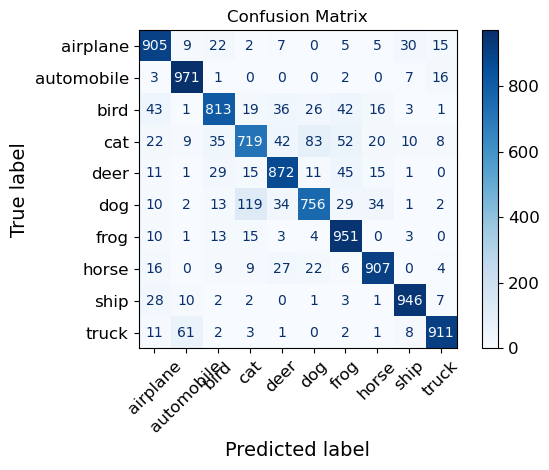

Classification Report:

              precision    recall  f1-score   support

    airplane       0.85      0.91      0.88      1000
  automobile       0.91      0.97      0.94      1000
        bird       0.87      0.81      0.84      1000
         cat       0.80      0.72      0.76      1000
        deer       0.85      0.87      0.86      1000
         dog       0.84      0.76      0.79      1000
        frog       0.84      0.95      0.89      1000
       horse       0.91      0.91      0.91      1000
        ship       0.94      0.95      0.94      1000
       truck       0.95      0.91      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.88      0.87     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr0p01__bs64__lrp2__minlr1e-07_

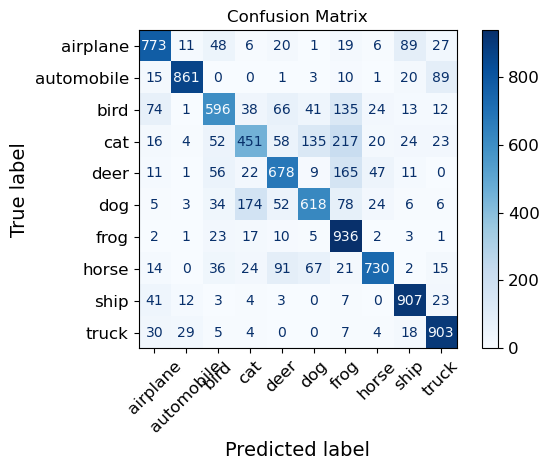

Classification Report:

              precision    recall  f1-score   support

    airplane       0.79      0.77      0.78      1000
  automobile       0.93      0.86      0.90      1000
        bird       0.70      0.60      0.64      1000
         cat       0.61      0.45      0.52      1000
        deer       0.69      0.68      0.69      1000
         dog       0.70      0.62      0.66      1000
        frog       0.59      0.94      0.72      1000
       horse       0.85      0.73      0.79      1000
        ship       0.83      0.91      0.87      1000
       truck       0.82      0.90      0.86      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr015-025-035-06__optsgd_m09_n1__lr1e-03__bs64__lrp2__minlr1e-0

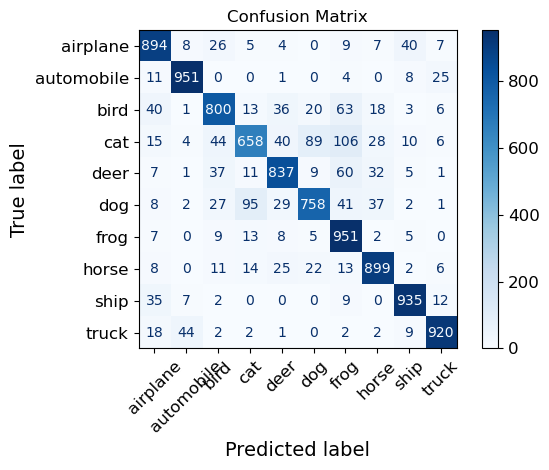

Classification Report:

              precision    recall  f1-score   support

    airplane       0.86      0.89      0.88      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.84      0.80      0.82      1000
         cat       0.81      0.66      0.73      1000
        deer       0.85      0.84      0.85      1000
         dog       0.84      0.76      0.80      1000
        frog       0.76      0.95      0.84      1000
       horse       0.88      0.90      0.89      1000
        ship       0.92      0.94      0.93      1000
       truck       0.93      0.92      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Metrics saved to saved_models/resultgrid/f128-128-256__dense256__dr015-025-035-06__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07/f128-128-256__dense256__dr015-025-035-06__optsgd_m09_n0__lr0p01__bs64__lrp2__minlr1e-07_

In [ ]:
import itertools

df_results = simple_grid_search(
    param_grid,
    X_train_new, y_train_new,
    X_val, y_val,
    X_test, y_test,
    classNames,
    augment,
    epochs=50
)

print(df_results.sort_values("val_acc", ascending=False).head())


# Step : Define grid search result function


In [ ]:
import numpy as np
import tensorflow as tf

def _load_model_from_row(row):
    save_dir = row["save_dir"]
    exp_name = row.get("exp_name", os.path.basename(save_dir.rstrip("/")))
    full_model = os.path.join(save_dir, f"{exp_name}_model.keras")
    if os.path.exists(full_model):
        return tf.keras.models.load_model(full_model)
    # fallback: rebuild + load best weights
    weights = os.path.join(save_dir, "best_model.weights.h5")
    model = create_flexible_model(
        filters=tuple(row["filters"]),
        dense_units=int(row["dense_units"]),
        dropout_rates=row["dropout_rates"]
    )
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=row["lr"]),
                  metrics=["accuracy"])
    if os.path.exists(weights):
        model.load_weights(weights)
    return model

def _sk_report(y_true, y_pred, class_names=None, digits=2):
    try:
        from sklearn.metrics import classification_report
        return classification_report(y_true, y_pred, target_names=class_names, digits=digits)
    except Exception:
        acc = (y_true == y_pred).mean()
        return f"Classification Report:\naccuracy: {acc:.4f}  (sklearn not available)"

def short_report(row, X_test, y_test, class_names=None, digits=2, batch_size=256):
    if y_test.ndim > 1 and y_test.shape[-1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test.reshape(-1)

    model = _load_model_from_row(row)
    y_prob = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    dr = row["dropout_rates"]
    hp_line = (
        f"filters={tuple(row['filters'])}  dense={int(row['dense_units'])}  "
        f"dropout(b1/b2/b3/d)={dr['block1']}/{dr['block2']}/{dr['block3']}/{dr['dense']}  "
        f"lr={row['lr']}  bs={row['batch_size']}  "
        f"lr_patience={row['lr_patience']}  min_lr={row['min_lr']}"
    )

    print("\n" + "="*72)
    print(hp_line + "\n")
    print(_sk_report(y_true, y_pred, class_names=class_names, digits=digits))
    print("="*72 + "\n")

def short_reports_topk(df, X_test, y_test, class_names=None, k=3, by="val_acc", digits=2):
    dd = df.sort_values(by, ascending=False).head(k).reset_index(drop=True)
    for _, row in dd.iterrows():
        short_report(row, X_test, y_test, class_names=class_names, digits=digits)


# Step : Run the grid search result function

In [ ]:
short_reports_topk(df_results, X_test, y_test, class_names=classNames, k=3, by="val_acc")



NameError: name 'df_results' is not defined